# Regression to Tbet Registration Pipeline

## Data loading

In [1]:
from sidus import io, tools as tl, plotting as pl # import input/output, editing tools, plotting as pl  
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ants
from sklearn.metrics import jaccard_score, f1_score
import SimpleITK as sitk
from skimage import exposure
import seaborn as sns
from scipy.stats import ttest_rel
# Fix for Dask DataFrame warning
from dask.config import set
set({"dataframe.query-planning": True})


c:\Users\molanre1\AppData\Local\miniconda3\envs\wsifir-env\lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


### Load clinical data

In [157]:
# Change file paths to your own
file_path = 'C:/Users/molanre1/Desktop/WSIFIR/'
samples_file = file_path + 'NAT_samples_12.2024.csv'

#Load the axis,regression and tbet clinical data
NAT_samples = pd.read_csv(samples_file)
NAT_samples.head(5)

,redcapid,sampleid,slideid,tbet_sampleid,tbet_slideid,reg_sampleid,reg_slideid,RFS,recurrence,lastfollowup,...,analysis_area,specimen_collection,included,paired,model_rvt,ln_status,tumor,regression,good_tissue,pseudo_patient_id
0,239,101,L1_2,834.0,AP0140001,709.0,LY1,83,1.0,2022-11-10 00:00:00,...,59.987766,Post,1,1,0.0,1,1,0,1,1
1,240,107,L2_4,835.0,AP0140002,710.0,LY2,2,0.0,2016-05-01 00:00:00,...,83.479162,Post,1,1,2.0,0,1,1,1,2
2,242,535,L4_3,837.0,AP0140004,712.0,LY4,34,0.0,2019-03-13 00:00:00,...,25.146146,Post,1,1,0.0,0,0,1,1,4
3,243,112,L5_1,838.0,AP0140005,713.0,LY5,47,0.0,2021-07-04 00:00:00,...,52.582683,Post,1,0,0.0,0,0,1,1,5
4,244,114,L6_1,839.0,AP0140006,714.0,LY6,51,0.0,2016-12-12 00:00:00,...,84.902509,Post,1,0,1.0,0,1,1,1,6


In [158]:
#Get corresponding images on each panel. Each row represents corresponding images
ids = NAT_samples[["sampleid","reg_sampleid","tbet_sampleid","slideid","reg_slideid","tbet_slideid"]].copy()

axis_sampleid = NAT_samples['sampleid']
reg_sampleid = NAT_samples['reg_sampleid']
tbet_sampleid = NAT_samples['tbet_sampleid']
axis_slideid = NAT_samples['slideid']
reg_slideid = NAT_samples['reg_slideid']
tbet_slideid = NAT_samples['tbet_slideid']

#Drop the rows with missing values
ids.dropna(inplace=True)

ids.head(46)

,sampleid,reg_sampleid,tbet_sampleid,slideid,reg_slideid,tbet_slideid
0,101,709.0,834.0,L1_2,LY1,AP0140001
1,107,710.0,835.0,L2_4,LY2,AP0140002
2,535,712.0,837.0,L4_3,LY4,AP0140004
3,112,713.0,838.0,L5_1,LY5,AP0140005
4,114,714.0,839.0,L6_1,LY6,AP0140006
5,118,715.0,840.0,L8_2,LY8,AP0140007
6,536,678.0,841.0,L9_3,AP0060001,AP0140008
7,537,679.0,842.0,L10_3,AP0060002,AP0140009
8,125,716.0,843.0,L11_3,LY11,AP0140010
9,129,717.0,844.0,L12_2,LY12,AP0140011


### Load in images from the database

In [156]:
#Initialize the row indexes for all the images

row_indexes = list(range(len(ids)))

# List to store all images
all_images = []

# Dictionary to store the results of each iteration
results = {}

# Extract the row from the ids table
for row_index in row_indexes:
    selected_row = ids.iloc[row_index]

    # Create variables for each column in the selected row
    reg_sampleid = selected_row['reg_sampleid']
    tbet_sampleid = selected_row['tbet_sampleid']
    reg_slideid = selected_row['reg_slideid']
    tbet_slideid = selected_row['tbet_slideid']

    # Convert variables to integers
    reg_sampleid = int(reg_sampleid)
    tbet_sampleid = int(tbet_sampleid)

    # Save the variables in the dictionary
    results[row_index] = {
        'reg_sampleid': reg_sampleid,
        'tbet_sampleid': tbet_sampleid,
        'reg_slideid': reg_slideid,
        'tbet_slideid': tbet_slideid
    }

    # Load the images
    reg_image = io.load_astropath(sampleid=reg_sampleid, sample_path=f'//bki-fs1/data02/Clinical_Specimen_10/{reg_slideid}', cells_table_path=False, cells_boundaries_path=False,cell_annotations_path=False, modaility='astropath')
    tbet_image = io.load_astropath(sampleid=tbet_sampleid, sample_path=f'//bki-fs1/data02/Clinical_Specimen_12/{tbet_slideid}', cells_table_path=False, cells_boundaries_path=False,cell_annotations_path=False, modaility='astropath')

     # Add images to the list
    all_images.extend([reg_image, tbet_image])

# Load the project with all images
sp = io.load_project(samples=all_images, merge_tables=True, modality='astropath')

#Display the spatial data
sp

KeyboardInterrupt: 

In [8]:
len(sp.images)

92

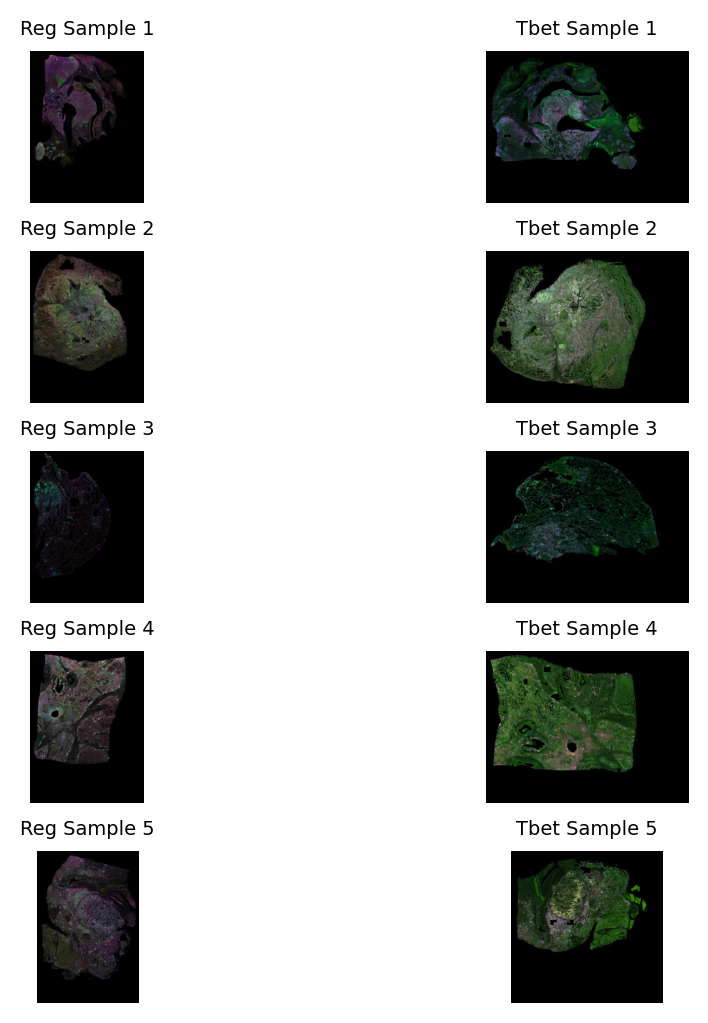

In [9]:
# Plot the first 5 images

pl.SubPlots(
    pl.ShowImage(sdata=sp, sampleid=results[0]['reg_sampleid'], title="Reg Sample 1"),  # reg_sampleid
    pl.ShowImage(sdata=sp, sampleid=results[0]['tbet_sampleid'], title="Tbet Sample 1"),  # tbet_sampleid

    pl.ShowImage(sdata=sp, sampleid=results[1]['reg_sampleid'], title="Reg Sample 2"),  # reg_sampleid
    pl.ShowImage(sdata=sp, sampleid=results[1]['tbet_sampleid'], title="Tbet Sample 2"),  # tbet_sampleid

    pl.ShowImage(sdata=sp, sampleid=results[2]['reg_sampleid'], title="Reg Sample 3"),  # reg_sampleid
    pl.ShowImage(sdata=sp, sampleid=results[2]['tbet_sampleid'], title="Tbet Sample 3"),  # tbet_sampleid

    pl.ShowImage(sdata=sp, sampleid=results[3]['reg_sampleid'], title="Reg Sample 4"),  # reg_sampleid
    pl.ShowImage(sdata=sp, sampleid=results[3]['tbet_sampleid'], title="Tbet Sample 4"),  # tbet_sampleid

    pl.ShowImage(sdata=sp, sampleid=results[4]['reg_sampleid'], title="Reg Sample 5"),  # reg_sampleid
    pl.ShowImage(sdata=sp, sampleid=results[4]['tbet_sampleid'], title="Tbet Sample 5"),  # tbet_sampleid
    figsize=(5, 5),
)

## Rigid Registration (Scale 9)

### Load in spatial data 

In [10]:
# Loop through each image in sp.images and crop it
cropped_images = {}
for sampleid in sp.images:
    cropped_images[sampleid] = tl.crop_xarray_image(sp.images[sampleid], scale=9)[0]


# Convert all images to numpy arrays

cropped_images_arrays = {}
for sampleid, cropped_image in cropped_images.items():
    cropped_images_arrays[sampleid] = cropped_image.compute()

In [12]:
# Convert all images to ants images
cropped_images_ants = {}
for sampleid, cropped_image in cropped_images_arrays.items():
    cropped_images_ants[sampleid] = ants.from_numpy(cropped_image)

cropped_images_ants


{'sampleid_709_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (96, 128)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_834_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (128, 96)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_710_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (96, 128)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_835_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (128, 96)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_712_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (96, 128)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_837_image': ANTsIma

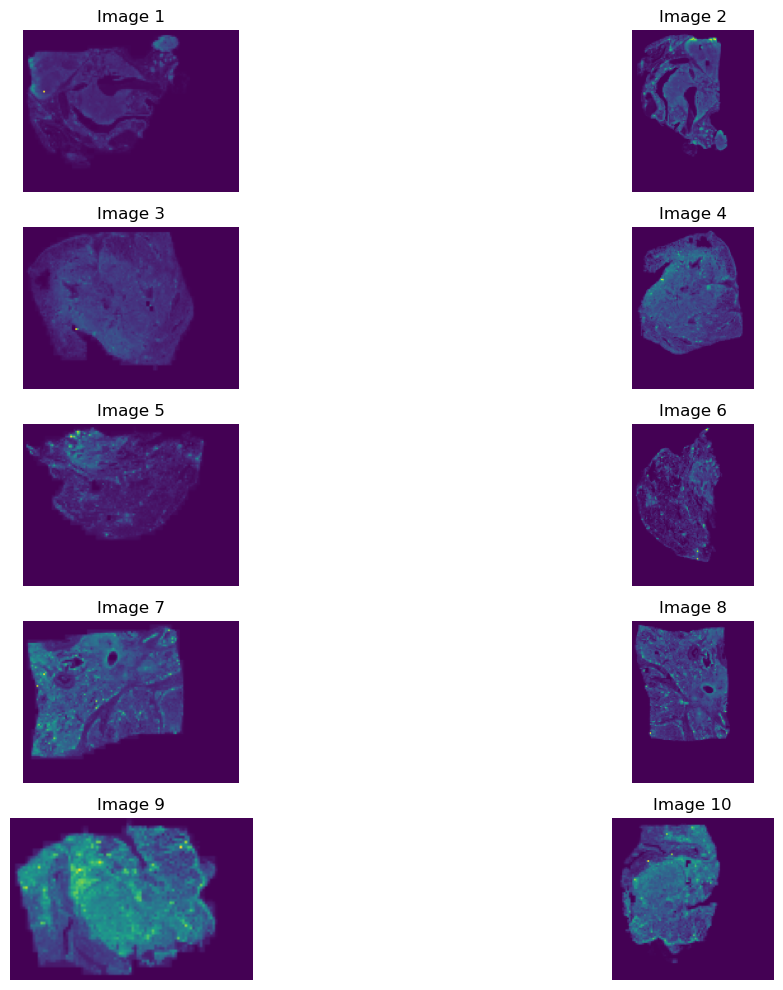

In [13]:
# Plot the first 10 images of cropped images using plt with 5 rows and 2 columns

fig, axes = plt.subplots(5, 2, figsize=(15, 10))
axes = axes.flatten()
for i, (sampleid, cropped_image) in enumerate(cropped_images_ants.items()):
    if i < 10:
        axes[i].imshow(cropped_image.numpy())
        axes[i].set_title(f'Image {i+1}')
        axes[i].axis('off')
plt.tight_layout()
plt.show()



### Pad images

In [14]:
# Create a function to pad all images in cropped_images_ants to the same size

def pad_images_to_same_size(images):
    # Get the maximum dimensions
    max_shape = np.max([img.shape for img in images.values()], axis=0)

    # Pad each image to the maximum dimensions
    padded_images = {}
    for sampleid, img in images.items():
        pad_width = [(0, max_dim - img.shape[i]) for i, max_dim in enumerate(max_shape)]
        padded_images[sampleid] = np.pad(img.numpy(), pad_width, mode='constant', constant_values=0)
    return padded_images
# Pad the images
padded_images = pad_images_to_same_size(cropped_images_ants)

# Convert the padded images to ANTs images
padded_images_ants = {}
for sampleid, padded_image in padded_images.items():
    padded_images_ants[sampleid] = ants.from_numpy(padded_image)

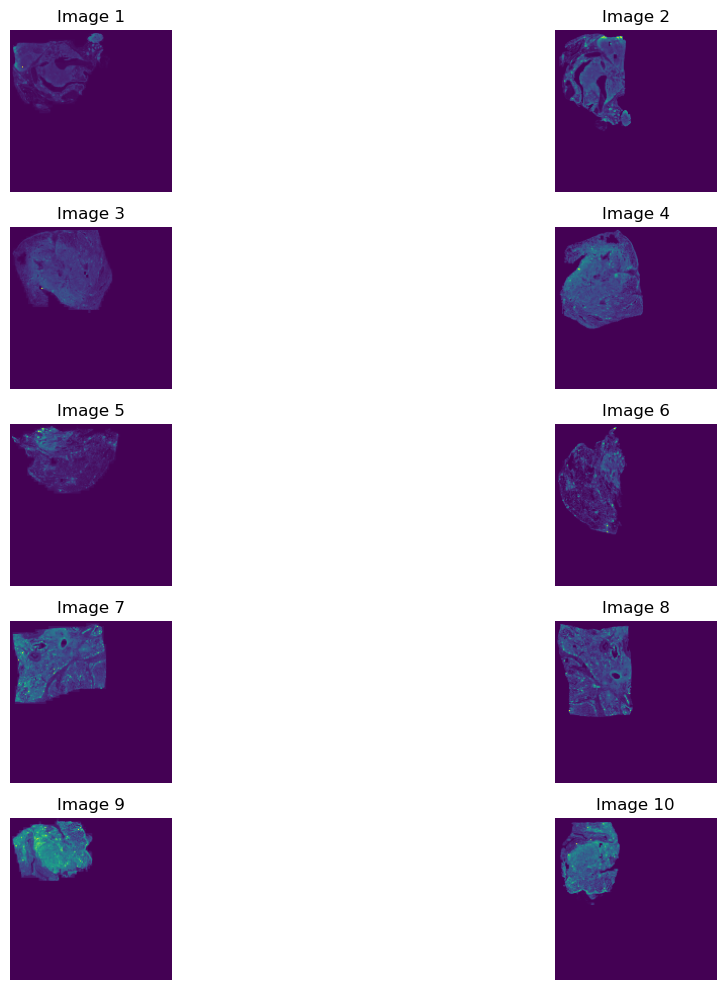

In [15]:
#Plot the first 10 images of padded images using plt with 5 rows and 2 columns
fig, axes = plt.subplots(5, 2, figsize=(15, 10))
axes = axes.flatten()
for i, (sampleid, padded_image) in enumerate(padded_images_ants.items()):
    if i < 10:
        axes[i].imshow(padded_image.numpy())
        axes[i].set_title(f'Image {i+1}')
        axes[i].axis('off')
plt.tight_layout()
plt.show()

In [16]:
# Store odd and even images in separate lists: regression and tbet while keeping the key

# Create lists to store regression and tbet image
# images

regression_images = []
tbet_images = []
for i, (sampleid, padded_image) in enumerate(padded_images_ants.items()):
    if i % 2 == 0:  # Even index
        regression_images.append((sampleid, padded_image))
    else:  # Odd index
        tbet_images.append((sampleid, padded_image))

In [17]:
regression_images

[('sampleid_709_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (160, 160)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_710_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (160, 160)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_712_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (160, 160)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_713_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (160, 160)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_714_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (160, 160)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Dire

In [18]:
tbet_images

[('sampleid_834_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (160, 160)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_835_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (160, 160)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_837_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (160, 160)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_838_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (160, 160)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_839_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (160, 160)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Dire

### ANTS Rigid transform 

In [159]:
#Register the regression images to the tbet images

registered_images = {}
for i, (reg_sampleid, reg_image) in enumerate(regression_images):
    # Get the corresponding tbet image
    tbet_sampleid, tbet_image = tbet_images[i]

    #Conduct  an affine initialization

    affine_init = ants.affine_initializer(reg_image, tbet_image, txfn=f'C:/Users/molanre1/Desktop/WSIFIR/scale_9_transform/reg_tbet/{reg_sampleid}_to_{tbet_sampleid}.txt')

    # Perform registration
    registered_image = ants.registration(fixed=reg_image, moving=tbet_image,initial_transform=affine_init, type_of_transform='Rigid',outprefix=f'C:/Users/molanre1/Desktop/WSIFIR/scale_9_transform/reg_tbet/{reg_sampleid}_to_{tbet_sampleid}_', verbose=True)

    # Store the registered image
    registered_images[reg_sampleid] = registered_image['warpedmovout']

    #Apply the transformation to the moving image
    transformed_image = ants.apply_transforms(fixed=reg_image, moving=tbet_image, transformlist=registered_image['fwdtransforms'])




antsRegistration -d 2 -r C:/Users/molanre1/Desktop/WSIFIR/scale_9_transform/reg_tbet/sampleid_709_image_to_sampleid_834_image.txt -m mattes[0000017A4C9A8188,0000017A41AEBEC8,1,32,regular,0.2] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:/Users/molanre1/Desktop/WSIFIR/scale_9_transform/reg_tbet/sampleid_709_image_to_sampleid_834_image_,0000017A41BB9868,0000017A41970488] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r C:/Users/molanre1/Desktop/WSIFIR/scale_9_transform/reg_tbet/sampleid_710_image_to_sampleid_835_image.txt -m mattes[0000017A41AEBEC8,0000017A260560A8,1,32,regular,0.2] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:/Users/molanre1/Desktop/WSIFIR/scale_9_transform/reg_tbet/sampleid_710_image_to_sampleid_835_image_,0000017A41BB9A68,0000017A4C9A8188] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r C:/Users/molanre1/Desktop/WSIFIR/scale_9_transform/reg_tbet/s

In [20]:
#Read the transformation matrices using ants.read_transform

transformation_matrices = {}
for i, (reg_sampleid, reg_image) in enumerate(regression_images):
    # Get the corresponding tbet image
    tbet_sampleid, tbet_image = tbet_images[i]

    # Read the transformation matrix
    transformation_matrix = ants.read_transform(f'C:/Users/molanre1/Desktop/WSIFIR/scale_9_transform/reg_tbet/{reg_sampleid}_to_{tbet_sampleid}_0GenericAffine.mat')
    transformation_matrices[reg_sampleid] = transformation_matrix


# Get the parameters and fixed parameters of the transformation matrices
transformation_parameters = {}
for sampleid, matrix in transformation_matrices.items():
    transformation_parameters[sampleid] = {
        'parameters': matrix.parameters,
        'fixed_parameters': matrix.fixed_parameters
    }

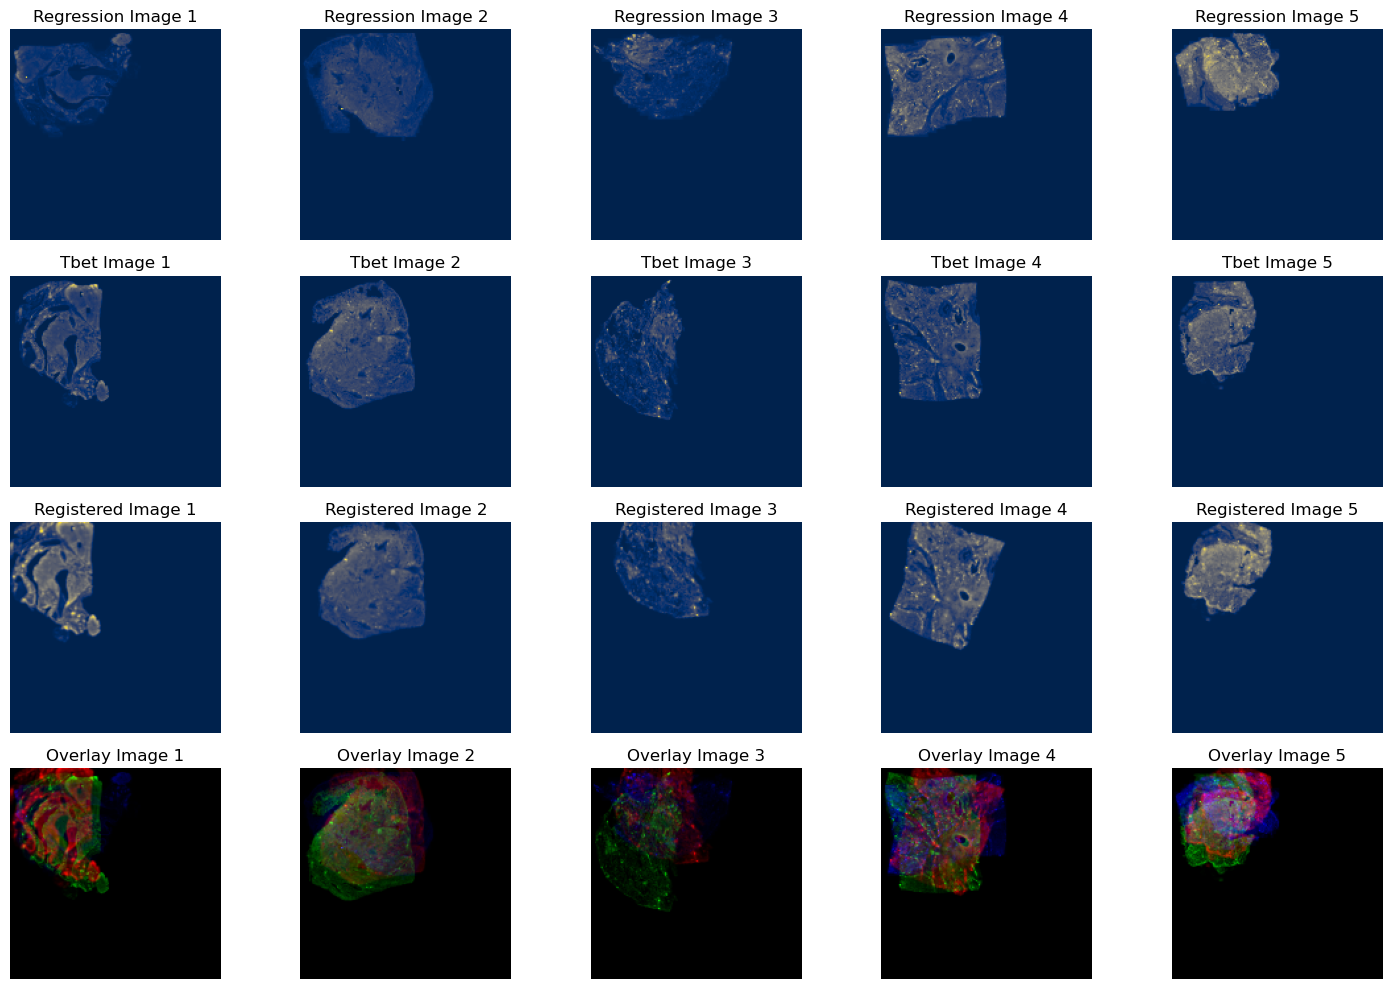

In [21]:
# Plot the first 5 regression images in one row, the corresponding tbet images in the second row,
# the registered images in the third row, and the overlay images in the last row.

fig, axes = plt.subplots(4, 5, figsize=(15, 10))
axes = axes.flatten()

# Plot regression images
for i, (sampleid, padded_image) in enumerate(regression_images):
    if i < 5:
        axes[i].imshow(padded_image.numpy(), cmap='cividis')
        axes[i].set_title(f'Regression Image {i+1}')
        axes[i].axis('off')

# Plot tbet images
for i, (sampleid, padded_image) in enumerate(tbet_images):
    if i < 5:
        axes[i + 5].imshow(padded_image.numpy(), cmap='cividis')
        axes[i + 5].set_title(f'Tbet Image {i+1}')
        axes[i + 5].axis('off')

# Plot registered images
for i, (sampleid, padded_image) in enumerate(registered_images.items()):
    if i < 5:
        axes[i + 10].imshow(padded_image.numpy(), cmap='cividis')
        axes[i + 10].set_title(f'Registered Image {i+1}')
        axes[i + 10].axis('off')

# Plot overlay images
for i, (reg_sampleid, reg_image) in enumerate(regression_images):
    if i < 5:
        # Get the corresponding tbet image
        tbet_sampleid, tbet_image = tbet_images[i]

        # Get the registered image
        registered_image = registered_images[reg_sampleid]

        # Normalize the images to 0-1 range
        registered_image = (registered_image - registered_image.min()) / (registered_image.max() - registered_image.min())
        tbet_image = (tbet_image - tbet_image.min()) / (tbet_image.max() - tbet_image.min())
        reg_image = (reg_image - reg_image.min()) / (reg_image.max() - reg_image.min())

        # Create a color image by stacking the images along the third dimension
        color_image = np.zeros((registered_image.shape[0], registered_image.shape[1], 3), dtype=np.float32)
        color_image[..., 0] = registered_image.numpy()  # Red channel (registered image)
        color_image[..., 1] = tbet_image.numpy()  # Green channel (tbet image)
        color_image[..., 2] = reg_image.numpy()  # Blue channel (regression image)

        axes[i + 15].imshow(color_image)
        axes[i + 15].set_title(f'Overlay Image {i+1}')
        axes[i + 15].axis('off')

plt.tight_layout()
plt.show()

### Metrics

In [22]:
#Compute mutual information, cross correlation, mse between the fixed regression and moving tbet images 

def compute_metrics(fixed_image, moving_image):

    # Compute Mutual Information
    mutual_info = ants.image_mutual_information(fixed_image, moving_image)

    # Compute Cross Correlation
    cross_corr = ants.math.image_similarity(fixed_image, moving_image,'Correlation')

    # Compute Mean Squared Error
    mse = ants.math.image_similarity(fixed_image, moving_image,'MeanSquares')

    #Binarize the images
    fixed_image_bin = (fixed_image.numpy()> 0.5).astype(int)
    moving_image_bin =  (moving_image.numpy() > 0.5).astype(int)
    # Compute Jaccard Index
    jaccard_index = jaccard_score(fixed_image_bin.flatten(), moving_image_bin.flatten(), average='weighted')
    
    #Compute the Dice coefficient
    f1 = f1_score(fixed_image_bin.flatten(), moving_image_bin.flatten(), average='weighted')

    # Get image from array
    fixed_image = sitk.GetImageFromArray(fixed_image.numpy())
    moving_image = sitk.GetImageFromArray(moving_image.numpy())

    #Compute the Hausdorff distance
    hausdoroff_distance = sitk.HausdorffDistanceImageFilter()
    hausdoroff_distance.Execute(fixed_image, moving_image)
    hausdoroff_distance_value = hausdoroff_distance.GetHausdorffDistance()

    return mutual_info, cross_corr, mse, jaccard_index, f1, hausdoroff_distance_value


In [79]:
#Create a dataframe with the regression and tbet images

metrics_df = pd.DataFrame(columns=['reg_sampleid', 'tbet_sampleid', 'Mutual Information', 'Cross Correlation', 'Mean Squared Error', 'Jaccard Index', 'F1 Score', 'Hausdorff Distance'])

# Loop through each image in the registered images

for i, (reg_sampleid, reg_image) in enumerate(regression_images):
    # Get the corresponding tbet image
    tbet_sampleid, tbet_image = tbet_images[i]

    # Compute metrics
    mutual_info, cross_corr, mse, jaccard_index, f1, hausdorff_distance_value = compute_metrics(reg_image, tbet_image)

    # Concantenate to the dataframe
    metrics_df = pd.concat([metrics_df, pd.DataFrame({
        'reg_sampleid': [reg_sampleid],
        'tbet_sampleid': [tbet_sampleid],
        'Mutual Information': [mutual_info],
        'Cross Correlation': [cross_corr],
        'Mean Squared Error': [mse],
        'Jaccard Index': [jaccard_index],
        'F1 Score': [f1],
        'Hausdorff Distance': [hausdorff_distance_value]
    })], ignore_index=True)


metrics_df.head(5)

C:\Users\molanre1\AppData\Local\Temp\2\ipykernel_56424\133295632.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, pd.DataFrame({


,reg_sampleid,tbet_sampleid,Mutual Information,Cross Correlation,Mean Squared Error,Jaccard Index,F1 Score,Hausdorff Distance
0,sampleid_709_image,sampleid_834_image,-0.111708,-0.155136,2.807429,0.813687,0.889695,30.083218
1,sampleid_710_image,sampleid_835_image,-0.222101,-0.471772,1.623008,0.786702,0.875717,22.135944
2,sampleid_712_image,sampleid_837_image,-0.056469,-0.079787,1.613973,0.715266,0.816073,45.177428
3,sampleid_713_image,sampleid_838_image,-0.202294,-0.326444,1.524908,0.796772,0.881775,23.769729
4,sampleid_714_image,sampleid_839_image,-0.183708,-0.398818,1.397672,0.866402,0.923192,24.000000


In [80]:
#Create a dataframe for the registered images and regression images
metrics_registered_images_df = pd.DataFrame(columns=['reg_sampleid', 'tbet_sampleid', 'Mutual Information', 'Cross Correlation', 'Mean Squared Error', 'Jaccard Index', 'F1 Score', 'Hausdorff Distance'])
# Loop through each image in the registered images

for i, (reg_sampleid, reg_image) in enumerate(registered_images.items()):
    # Get the corresponding regression image
    reg_sampleid, reg_image = regression_images[i]

#Compute metrics
    mutual_info, cross_corr, mse, jaccard_index, f1, hausdorff_distance_value = compute_metrics(reg_image, registered_image)


 # Concatenate to the dataframe
    metrics_registered_images_df = pd.concat([metrics_registered_images_df, pd.DataFrame({
            'reg_sampleid': [reg_sampleid],
            'tbet_sampleid': [tbet_sampleid],
            'Mutual Information': [mutual_info],
            'Cross Correlation': [cross_corr],
            'Mean Squared Error': [mse],
            'Jaccard Index': [jaccard_index],
            'F1 Score': [f1],
            'Hausdorff Distance': [hausdorff_distance_value]
        })], ignore_index=True)
    

metrics_registered_images_df.head(5)


        


C:\Users\molanre1\AppData\Local\Temp\2\ipykernel_56424\1506324144.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_registered_images_df = pd.concat([metrics_registered_images_df, pd.DataFrame({


,reg_sampleid,tbet_sampleid,Mutual Information,Cross Correlation,Mean Squared Error,Jaccard Index,F1 Score,Hausdorff Distance
0,sampleid_709_image,sampleid_893_image,-0.109297,-0.163528,1.603219,0.798184,0.878752,25.961510
1,sampleid_710_image,sampleid_893_image,-0.227082,-0.450852,0.883110,0.805624,0.886514,20.615528
2,sampleid_712_image,sampleid_893_image,-0.212317,-0.340479,1.121794,0.861256,0.921386,21.931712
3,sampleid_713_image,sampleid_893_image,-0.206186,-0.261574,1.221926,0.800849,0.882793,23.000000
4,sampleid_714_image,sampleid_893_image,-0.155475,-0.317872,1.145923,0.831362,0.900768,26.019224


In [81]:
metrics_df.drop(columns=['reg_sampleid','tbet_sampleid'], inplace=True)
metrics_registered_images_df.drop(columns=['reg_sampleid','tbet_sampleid'], inplace=True)

In [148]:
# Compute the mean and standard deviation of the metrics
metrics_mean = metrics_df.mean()
metrics_std = metrics_df.std()
metrics_registered_images_mean = metrics_registered_images_df.mean()
metrics_registered_images_std = metrics_registered_images_df.std()
# Create a dataframe with the mean and standard deviation of the metrics
metrics_mean_df = pd.DataFrame({
    'Mean': metrics_mean,
    'Standard Deviation': metrics_std
})
metrics_registered_images_mean_df = pd.DataFrame({
    'Mean': metrics_registered_images_mean,
    'Standard Deviation': metrics_registered_images_std
})

# Concatenate the two dataframes
metrics_combined_df = pd.concat([metrics_mean_df['Mean'], metrics_registered_images_mean_df['Mean'], metrics_mean_df['Standard Deviation'], metrics_registered_images_mean_df['Standard Deviation']], axis=1) 
metrics_combined_df.columns = ['Mean', 'Mean Registered', 'Standard Deviation', 'Standard Deviation Registered']
metrics_combined_df

,Mean,Mean Registered,Standard Deviation,Standard Deviation Registered
Mutual Information,-0.098731,-0.135446,0.076020,0.064124
Cross Correlation,-0.170202,-0.213907,0.145544,0.116834
Mean Squared Error,1.881432,1.399498,1.056068,0.273143
Jaccard Index,0.781819,0.803358,0.102484,0.030038
F1 Score,0.860366,0.881909,0.072904,0.020969
Hausdorff Distance,38.798513,32.233675,16.549634,12.376994


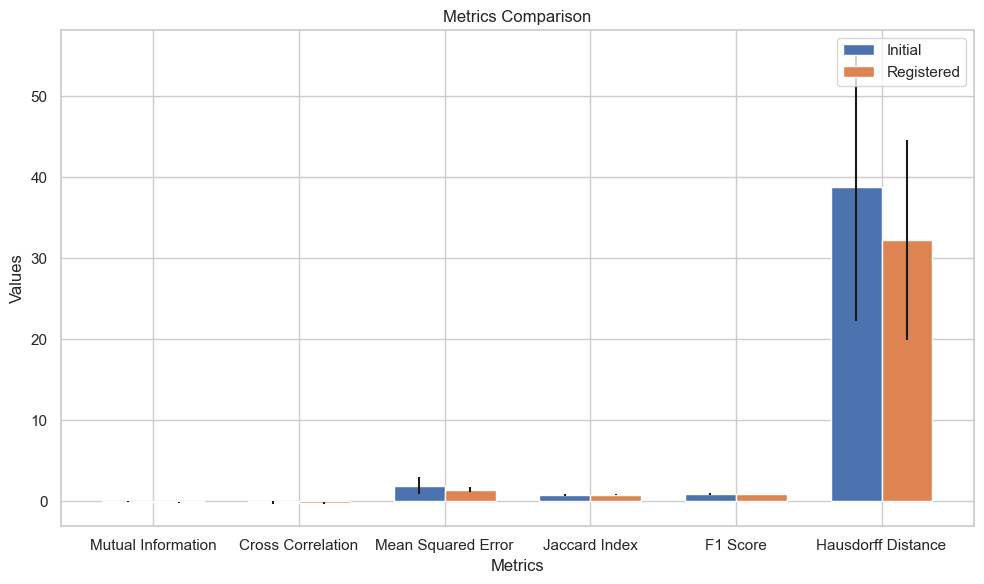

In [153]:
# Create grouped bar plots for the metrics and metrics_registered_images for each metric without hausdorff distance

def plot_grouped_bar_chart(df1, df2, title):
    # Set the figure size
    plt.figure(figsize=(10, 6))

    # Set the bar width
    bar_width = 0.35

    # Set the x locations for the bars
    x = np.arange(len(df1))

    # Create the bars for df1
    plt.bar(x, df1['Mean'], yerr=df1['Standard Deviation'], width=bar_width, label='Initial')

    # Create the bars for df2
    plt.bar(x + bar_width, df2['Mean'], yerr=df2['Standard Deviation'], width=bar_width, label='Registered')

    # Add labels and title
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.title(title)
    plt.xticks(x + bar_width / 2, df1.index)
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()
# Plot the grouped bar chart for metrics_df and metrics_registered_images_df
plot_grouped_bar_chart(metrics_mean_df, metrics_registered_images_mean_df, 'Metrics Comparison')

In [154]:
# Compute the difference between the metrics of the mean
diff_mean = metrics_registered_images_mean_df['Mean'] - metrics_mean_df['Mean']

# Create a dataframe with the difference between the metrics of the mean and standard deviation
diff_df = pd.DataFrame({
    'Difference Mean': diff_mean,
})

diff_df

,Difference Mean
Mutual Information,-0.036716
Cross Correlation,-0.043705
Mean Squared Error,-0.481934
Jaccard Index,0.021539
F1 Score,0.021543
Hausdorff Distance,-6.564838


In [155]:
# Save the DataFrame to CSV file
diff_df.to_csv('C:/Users/molanre1/Desktop/WSIFIR/scale_9_transform/reg_tbet_metrics_diff_mean_df.csv', index=False)

In [94]:
#Convert each set of corresponding tissue slices into a DataFrame
#Each row has the same tissue, but 2 different slices representing the same tissue stained with regression and tbet panels

# Create a DataFrame to store the merged images
merged_df = pd.DataFrame(columns=['reg_sampleid', 'tbet_sampleid','final_image_parameters', 'final_image_fixed_parameters'])

# Loop through each image and concate to the DataFrame

for i, (reg_sampleid, reg_image) in enumerate(registered_images.items()):
    # Get the corresponding tbet image
    tbet_sampleid, tbet_image = tbet_images[i]

    # Get the transformation matrix
    transformation_matrix = transformation_matrices[reg_sampleid]

    # Append the metrics to the DataFrame
    merged_df = pd.concat([merged_df, pd.DataFrame({
        'reg_sampleid': [reg_sampleid],
        'tbet_sampleid': [tbet_sampleid],
        'final_image_parameters': [transformation_matrix.parameters],
        'final_image_fixed_parameters': [transformation_matrix.fixed_parameters]
    })], ignore_index=True)

merged_df.head(10)

,reg_sampleid,tbet_sampleid,final_image_parameters,final_image_fixed_parameters
0,sampleid_709_image,sampleid_834_image,"[0.9998042583465576, 0.0003065355122089386, -0...","[35.215389251708984, 41.98567581176758]"
1,sampleid_710_image,sampleid_835_image,"[0.995846152305603, -0.08562920987606049, 0.08...","[42.120697021484375, 52.78548049926758]"
2,sampleid_712_image,sampleid_837_image,"[0.9531788229942322, 0.3024073541164398, -0.30...","[28.47519302368164, 50.77205276489258]"
3,sampleid_713_image,sampleid_838_image,"[0.9194219708442688, -0.3932725787162781, 0.39...","[39.62575912475586, 44.546478271484375]"
4,sampleid_714_image,sampleid_839_image,"[0.9224770665168762, -0.38605189323425293, 0.3...","[30.321826934814453, 41.447025299072266]"
5,sampleid_715_image,sampleid_840_image,"[0.9120522141456604, 0.41013967990875244, -0.4...","[36.37406921386719, 45.331546783447266]"
6,sampleid_678_image,sampleid_841_image,"[0.9366250038146973, -0.350333571434021, 0.350...","[39.46842575073242, 36.75742721557617]"
7,sampleid_679_image,sampleid_842_image,"[0.9980475902557373, -0.03490271046757698, 0.0...","[10.761759757995605, 11.912997245788574]"
8,sampleid_716_image,sampleid_843_image,"[0.9484118819236755, 0.3171784281730652, -0.31...","[31.23196792602539, 37.17987823486328]"
9,sampleid_717_image,sampleid_844_image,"[0.950357973575592, 0.31115856766700745, -0.31...","[32.858036041259766, 43.60976791381836]"


In [95]:
#Save the merged DataFrame to a CSV file
merged_df.to_csv('C:/Users/molanre1/Desktop/WSIFIR/xform_reg_to_tbet_scale_9.csv', index=False)

## Rigid Registration (Scale 7)

### Load in spatial data

In [160]:
# Loop through each image in sp.images and crop it
cropped_images_2 = {}
for sampleid in sp.images:
    cropped_images_2[sampleid] = tl.crop_xarray_image(sp.images[sampleid], scale=7)[0]


In [161]:
# Convert all images to numpy arrays
cropped_images_arrays_2 = {}
for sampleid, cropped_image in cropped_images_2.items():
    cropped_images_arrays_2[sampleid] = cropped_image.compute()

In [162]:
#Convert all images to ants images
cropped_images_ants_2 = {}
for sampleid, cropped_image in cropped_images_arrays_2.items():
    cropped_images_ants_2[sampleid] = ants.from_numpy(cropped_image)
cropped_images_ants_2

{'sampleid_709_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (384, 512)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_834_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (512, 384)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_710_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (384, 512)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_835_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (512, 384)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_712_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (384, 512)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_837_image': AN

### Pad images

In [163]:
# Pad the images
padded_images_2 = pad_images_to_same_size(cropped_images_ants_2)

# Convert the padded images to ANTs images
padded_images_ants_2 = {}
for sampleid, padded_image in padded_images_2.items():
    padded_images_ants_2[sampleid] = ants.from_numpy(padded_image)

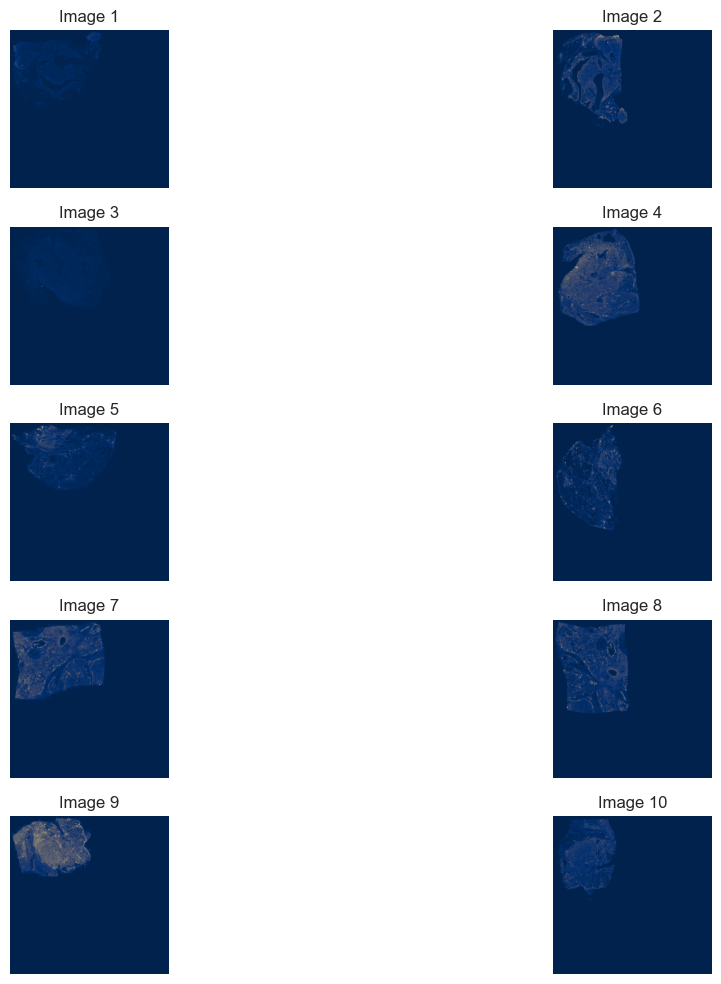

In [164]:
#Plot the first 10 images of padded images using plt with 5 rows and 2 columns
fig, axes = plt.subplots(5, 2, figsize=(15, 10))
axes = axes.flatten()
for i, (sampleid, padded_image) in enumerate(padded_images_ants_2.items()):
    if i < 10:
        axes[i].imshow(padded_image.numpy(), cmap='cividis')
        axes[i].set_title(f'Image {i+1}')
        axes[i].axis('off')
plt.tight_layout()
plt.show()

In [165]:
#Store odd and even images in separate lists: regression and tbet while keeping the key
# Create lists to store regression and tbet image
# images
regression_images_2 = []
tbet_images_2 = []
for i, (sampleid, padded_image) in enumerate(padded_images_ants_2.items()):
    if i % 2 == 0:  # Even index
        regression_images_2.append((sampleid, padded_image))
    else:  # Odd index
        tbet_images_2.append((sampleid, padded_image))


### Scale and apply registration parameters at lower resolution to higher resolution image

In [166]:
def compute_scaling_factor(higher_res_scale, lower_res_scale):
    """
    Compute the scaling factor based on the image transformations.
    """
    # Directly compute the scaling factor as a scalar
    return lower_res_scale / higher_res_scale

def scale_transform(transform_path, scaling_factors):
    """
    Scale a 2D affine transformation matrix while preserving rotation components.
    
    Parameters:
        transform_path (str): Path to the original transformation matrix (.mat file).
        scaling_factors (list or float): Scaling factors for translation components. 
                                         Can be a scalar or a list of 2 values for 2D transformations.
    
    Returns:
        str: Path to the scaled transformation matrix.
    """
    try:
        # Read the transformation matrix
        transform = ants.read_transform(transform_path)
        
        # Ensure the transform is 2D
        if transform.dimension != 2:
            raise ValueError("This function only supports 2D transformations.")
        
        # Extract the transformation parameters
        parameters = np.array(transform.parameters)  # Convert to a NumPy array for easier manipulation
        
        # Validate scaling_factors
        if isinstance(scaling_factors, (int, float)):  # If scalar, apply uniformly
            scaling_factors = [scaling_factors] * 2
        elif len(scaling_factors) != 2:
            raise ValueError("Scaling factors must be a scalar or a list of 2 values for 2D transformations.")
        
        # Scale only the translation components (last two parameters for tx, ty in 2D affine)
        scaled_parameters = parameters.copy()
        if len(parameters) >= 6:  # Ensure there are enough parameters for a 2D affine transform
            scaled_parameters[4:6] *= scaling_factors  # Scale translation components (tx, ty)
        else:
            raise ValueError("Transformation parameters do not have enough components to scale translation.")
        
        # Create a new transform with the scaled parameters
        scaled_transform = ants.create_ants_transform(
            transform_type=transform.type,  # Use the same transform type
            dimension=transform.dimension,  # Use the same dimension (2D)
            parameters=scaled_parameters.tolist(),  # Convert back to a list
            fixed_parameters=transform.fixed_parameters  # Keep the fixed parameters unchanged
        )
        
        # Save the scaled transformation matrix
        scaled_transform_path = transform_path.replace('.mat', '_scaled.mat')
        ants.write_transform(scaled_transform, scaled_transform_path)
        
        return scaled_transform_path
    
    except Exception as e:
        raise RuntimeError(f"Error scaling transform: {e}")



In [167]:
#Compute the scaling factor between an image from scale 9 and scale 7

scaling_factor_1 = compute_scaling_factor(sp.images[f'{list(sp.images)[0]}']['scale7'].image.transform['scale0'].scale[0], sp.images[f'{list(sp.images)[0]}']['scale9'].image.transform['scale0'].scale[0])

#Convert the scaling factors to be floats
scaling_factor_1 = float(scaling_factor_1)

In [168]:
#For each image in the registered images, scale the transformation matrix
for i, (reg_sampleid, reg_image) in enumerate(registered_images.items()):
    # Get the corresponding tbet image
    tbet_sampleid, tbet_image = tbet_images[i]

    # Get the transformation matrix
    transform_path = f'C:/Users/molanre1/Desktop/WSIFIR/scale_9_transform/reg_tbet/{reg_sampleid}_to_{tbet_sampleid}_0GenericAffine.mat'

    # Scale the transformation matrix
    scaled_transform_path = scale_transform(transform_path, scaling_factor_1)

    #Store the scaled transformation matrix
    transformation_matrices[reg_sampleid] = scaled_transform_path

### ANTS Rigid transform

In [169]:
#Perform the registration using the scaled transformation matrix
registered_images_scaled = {}

for i, (reg_sampleid, reg_image) in enumerate(regression_images_2):
    # Get the corresponding tbet image
    tbet_sampleid, tbet_image = tbet_images_2[i]

    # Perform registration using the scaled transformation matrix
    registered_image = ants.registration(fixed=reg_image, moving=tbet_image, initial_transform=transformation_matrices[reg_sampleid], type_of_transform='Rigid', outprefix=f'C:/Users/molanre1/Desktop/WSIFIR/scale_7_transform/reg_tbet/{reg_sampleid}_to_{tbet_sampleid}_', verbose=True)

    # Store the registered image
    registered_images_scaled[reg_sampleid] = registered_image['warpedmovout']

antsRegistration -d 2 -r C:/Users/molanre1/Desktop/WSIFIR/scale_9_transform/reg_tbet/sampleid_709_image_to_sampleid_834_image_0GenericAffine_scaled.mat -m mattes[0000017A41BB9E48,0000017A260E8D08,1,32,regular,0.2] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:/Users/molanre1/Desktop/WSIFIR/scale_7_transform/reg_tbet/sampleid_709_image_to_sampleid_834_image_,0000017A41BB9E68,0000017A41BB9F68] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r C:/Users/molanre1/Desktop/WSIFIR/scale_9_transform/reg_tbet/sampleid_710_image_to_sampleid_835_image_0GenericAffine_scaled.mat -m mattes[0000017A260E8D08,0000017A41DD6B08,1,32,regular,0.2] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:/Users/molanre1/Desktop/WSIFIR/scale_7_transform/reg_tbet/sampleid_710_image_to_sampleid_835_image_,0000017A41BB9F68,0000017A41BB9E68] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r C:/Users/molanre1

In [170]:
#Read the transformation matrices using ants.read_transform

transformation_matrices_scaled = {}

for i, (reg_sampleid, reg_image) in enumerate(regression_images_2):
    # Get the corresponding tbet image
    tbet_sampleid, tbet_image = tbet_images_2[i]

    # Read the transformation matrix
    transformation_matrix = ants.read_transform(f'C:/Users/molanre1/Desktop/WSIFIR/scale_7_transform/reg_tbet/{reg_sampleid}_to_{tbet_sampleid}_0GenericAffine.mat')
    transformation_matrices_scaled[reg_sampleid] = transformation_matrix

# Get the parameters and fixed parameters of the transformation matrices
transformation_parameters_scaled = {}
for sampleid, matrix in transformation_matrices_scaled.items():
    transformation_parameters_scaled[sampleid] = {
        'parameters': matrix.parameters,
        'fixed_parameters': matrix.fixed_parameters
    }

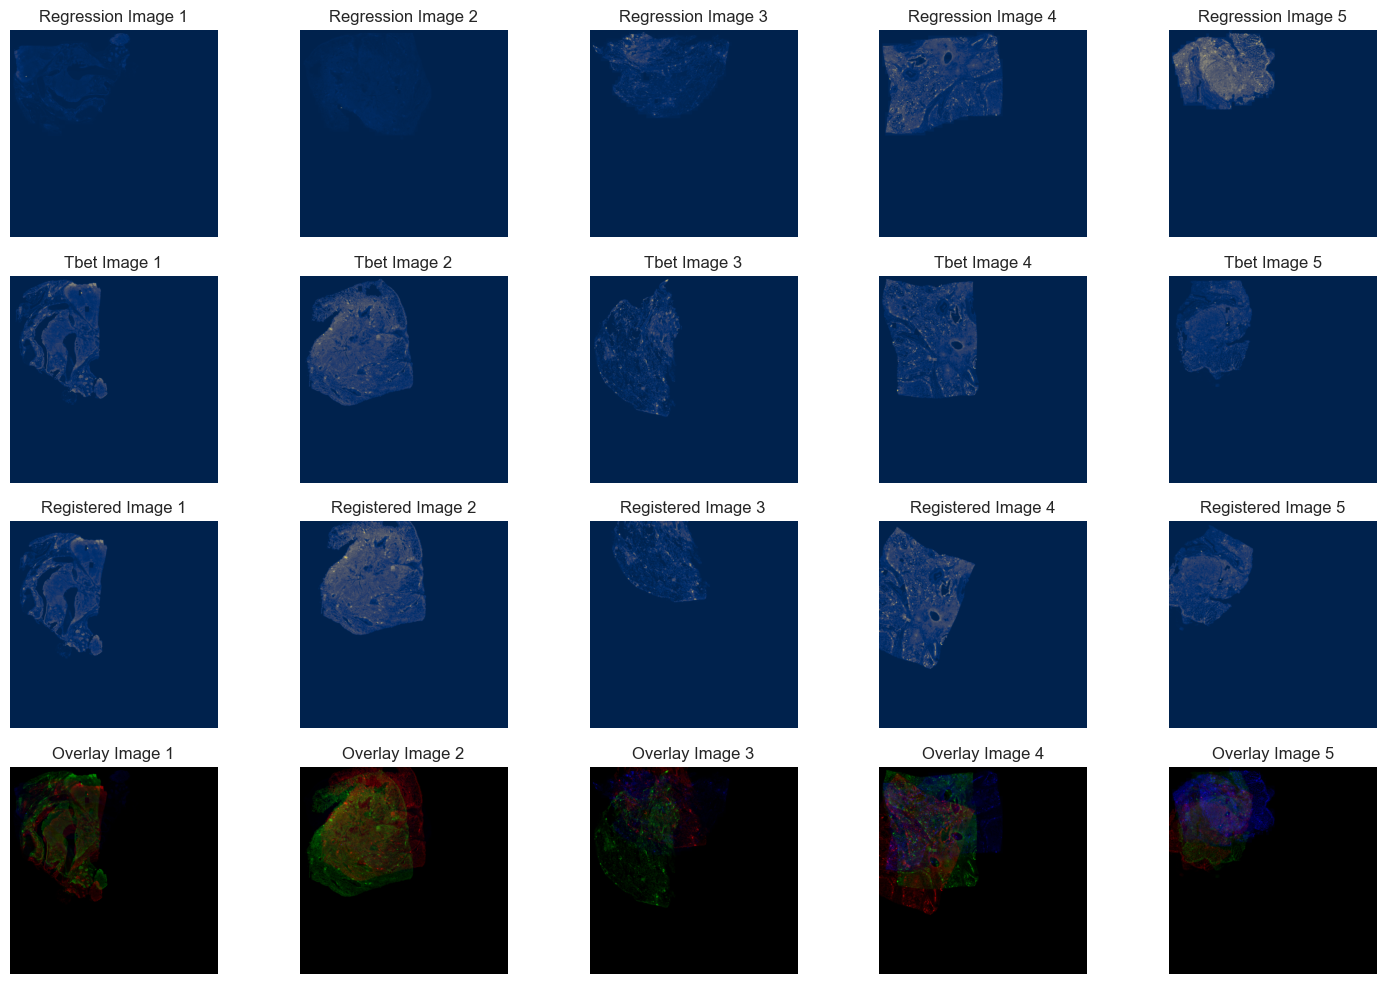

In [172]:
# Plot the first 5 regression images in one row, the corresponding tbet images in the second row,
# the registered images in the third row, and the overlay images in the last row.

fig, axes = plt.subplots(4, 5, figsize=(15, 10))
axes = axes.flatten()
# Plot regression images
for i, (sampleid, padded_image) in enumerate(regression_images_2):
    if i < 5:
        axes[i].imshow(padded_image.numpy(), cmap='cividis')
        axes[i].set_title(f'Regression Image {i+1}')
        axes[i].axis('off')
# Plot tbet images
for i, (sampleid, padded_image) in enumerate(tbet_images_2):
    if i < 5:
        axes[i + 5].imshow(padded_image.numpy(), cmap='cividis')
        axes[i + 5].set_title(f'Tbet Image {i+1}')
        axes[i + 5].axis('off')
# Plot registered images
for i, (sampleid, padded_image) in enumerate(registered_images_scaled.items()):
    if i < 5:
        axes[i + 10].imshow(padded_image.numpy(), cmap='cividis')
        axes[i + 10].set_title(f'Registered Image {i+1}')
        axes[i + 10].axis('off')
# Plot overlay images

for i, (reg_sampleid, reg_image) in enumerate(regression_images_2):
    if i < 5:
        # Get the corresponding tbet image
        tbet_sampleid, tbet_image = tbet_images_2[i]

        # Get the registered image
        registered_image = registered_images_scaled[reg_sampleid]

        # Normalize the images to 0-1 range
        registered_image = (registered_image - registered_image.min()) / (registered_image.max() - registered_image.min())
        tbet_image = (tbet_image - tbet_image.min()) / (tbet_image.max() - tbet_image.min())
        reg_image = (reg_image - reg_image.min()) / (reg_image.max() - reg_image.min())

        # Create a color image by stacking the images along the third dimension
        color_image = np.zeros((registered_image.shape[0], registered_image.shape[1], 3), dtype=np.float32)
        color_image[..., 0] = registered_image.numpy()  # Red channel (registered image)
        color_image[..., 1] = tbet_image.numpy()  # Green channel (tbet image)
        color_image[..., 2] = reg_image.numpy()  # Blue channel (regression image)

        axes[i + 15].imshow(color_image)
        axes[i + 15].set_title(f'Overlay Image {i+1}')
        axes[i + 15].axis('off')
plt.tight_layout()
plt.show()

### Metrics

In [179]:

#Create a dataframe with the regression and tbet images

metrics_df_2 = pd.DataFrame(columns=['reg_sampleid', 'tbet_sampleid', 'Mutual Information', 'Cross Correlation', 'Mean Squared Error', 'Jaccard Index', 'F1 Score', 'Hausdorff Distance'])
# Loop through each image in the registered images

for i, (reg_sampleid, reg_image) in enumerate(regression_images_2):
    # Get the corresponding tbet image
    tbet_sampleid, tbet_image = tbet_images_2[i]

    # Compute metrics
    mutual_info, cross_corr, mse, jaccard_index, f1, hausdorff_distance_value = compute_metrics(reg_image, tbet_image)

    # Concatenate to the dataframe
    metrics_df_2 = pd.concat([metrics_df_2, pd.DataFrame({
        'reg_sampleid': [reg_sampleid],
        'tbet_sampleid': [tbet_sampleid],
        'Mutual Information': [mutual_info],
        'Cross Correlation': [cross_corr],
        'Mean Squared Error': [mse],
        'Jaccard Index': [jaccard_index],
        'F1 Score': [f1],
        'Hausdorff Distance': [hausdorff_distance_value]
    })], ignore_index=True)


metrics_df_2.head(5)

C:\Users\molanre1\AppData\Local\Temp\2\ipykernel_56424\3257985079.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df_2 = pd.concat([metrics_df_2, pd.DataFrame({


,reg_sampleid,tbet_sampleid,Mutual Information,Cross Correlation,Mean Squared Error,Jaccard Index,F1 Score,Hausdorff Distance
0,sampleid_709_image,sampleid_834_image,-0.029965,-0.115184,3.501206,0.807768,0.884572,120.880106
1,sampleid_710_image,sampleid_835_image,-0.045865,-0.386171,1.983336,0.781990,0.872130,91.093359
2,sampleid_712_image,sampleid_837_image,-0.022705,-0.047078,2.348373,0.743213,0.833802,178.846303
3,sampleid_713_image,sampleid_838_image,-0.137998,-0.227197,2.123869,0.785974,0.873890,96.772930
4,sampleid_714_image,sampleid_839_image,-0.130531,-0.322454,1.738255,0.868578,0.924257,96.000000


In [ ]:
metrics_df_2.drop(columns=['reg_sampleid','tbet_sampleid'], inplace=True)

In [186]:
# Create a dataframe to store the metrics between the registered images and the regression images

metrics_df_registered_2 = pd.DataFrame(columns=['reg_sampleid', 'tbet_sampleid', 'Mutual Information', 'Cross Correlation', 'Mean Squared Error', 'Jaccard Index', 'F1 Score', 'Hausdorff Distance'])

for i, (reg_sampleid, reg_image) in enumerate(registered_images_scaled.items()):
    # Get the corresponding tbet image
    tbet_sampleid, tbet_image = tbet_images_2[i]

    # Compute the metrics
    mutual_info, cross_corr, mse, jaccard_index, f1, hausdorff_distance = compute_metrics(reg_image, registered_image)

    # Append the metrics to the DataFrame
    metrics_df_registered_2 = pd.concat([metrics_df_registered_2, pd.DataFrame({
        'reg_sampleid': [reg_sampleid],
        'tbet_sampleid': [tbet_sampleid],
        'Mutual Information': [mutual_info],
        'Cross Correlation': [cross_corr],
        'Mean Squared Error': [mse],
        'Jaccard Index': [jaccard_index],
        'F1 Score': [f1],
        'Hausdorff Distance': [hausdorff_distance]
    })], ignore_index=True)

metrics_df_registered_2.head(5)


C:\Users\molanre1\AppData\Local\Temp\2\ipykernel_56424\1938837286.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df_registered_2 = pd.concat([metrics_df_registered_2, pd.DataFrame({


,reg_sampleid,tbet_sampleid,Mutual Information,Cross Correlation,Mean Squared Error,Jaccard Index,F1 Score,Hausdorff Distance
0,sampleid_709_image,sampleid_834_image,-0.088958,-0.185839,3.938498,0.709009,0.769858,163.131849
1,sampleid_710_image,sampleid_835_image,-0.065360,-0.161518,3.447662,0.601766,0.677797,180.759509
2,sampleid_712_image,sampleid_837_image,-0.019550,-0.044786,1.425948,0.792507,0.838568,166.207701
3,sampleid_713_image,sampleid_838_image,-0.108583,-0.199477,2.746731,0.637141,0.708670,135.591298
4,sampleid_714_image,sampleid_839_image,-0.414529,-1.000000,2.453456,0.757351,0.809932,0.000000


In [191]:

metrics_df_registered_2.drop(columns=['reg_sampleid', 'tbet_sampleid'], inplace=True)

In [192]:
# Compute the mean and standard deviation of the metrics
metrics_mean_2 = metrics_df_2.mean()
metrics_std_2 = metrics_df_2.std()
metrics_registered_images_mean_2 = metrics_df_registered_2.mean()
metrics_registered_images_std_2 = metrics_df_registered_2.std()
# Create a dataframe with the mean and standard deviation of the metrics
metrics_mean_df_2 = pd.DataFrame({
    'Mean': metrics_mean_2,
    'Standard Deviation': metrics_std_2
})
metrics_registered_images_mean_df_2 = pd.DataFrame({
    'Mean': metrics_registered_images_mean_2,
    'Standard Deviation': metrics_registered_images_std_2
})
# Concatenate the two dataframes
metrics_combined_df_2 = pd.concat([metrics_mean_df_2['Mean'], metrics_registered_images_mean_df_2['Mean'], metrics_mean_df_2['Standard Deviation'], metrics_registered_images_mean_df_2['Standard Deviation']], axis=1)
metrics_combined_df_2.columns = ['Mean', 'Mean Registered', 'Standard Deviation', 'Standard Deviation Registered']
metrics_combined_df_2

,Mean,Mean Registered,Standard Deviation,Standard Deviation Registered
Mutual Information,-0.056244,-0.063571,0.047507,0.068236
Cross Correlation,-0.131091,-0.145917,0.117536,0.160783
Mean Squared Error,2.288185,2.273896,1.264971,1.321959
Jaccard Index,0.783283,0.763389,0.101111,0.103338
F1 Score,0.860592,0.813113,0.072131,0.084424
Hausdorff Distance,155.093159,157.424840,65.953545,61.916667


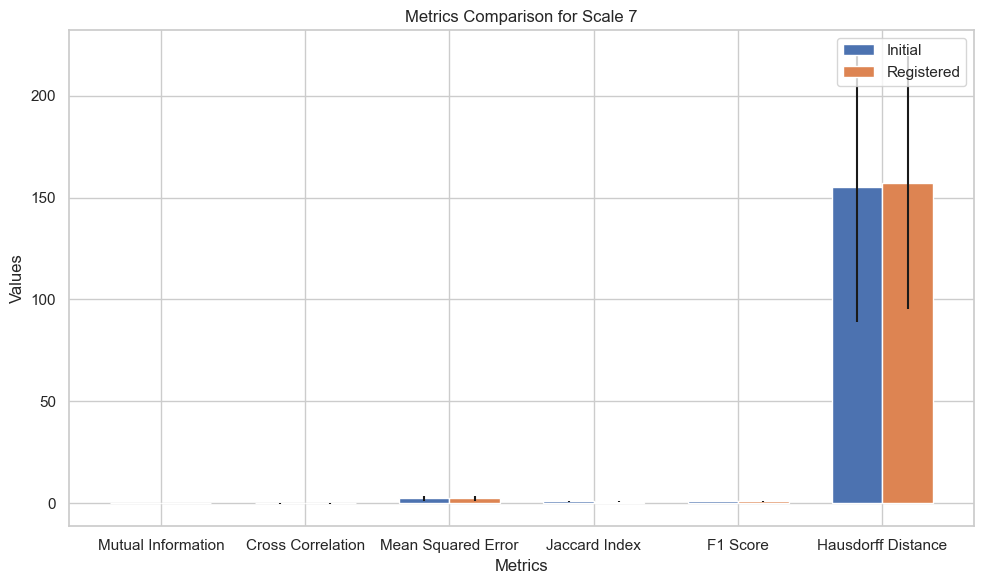

In [193]:
# Plot the grouped bar chart for metrics_df and metrics_registered_images_df
plot_grouped_bar_chart(metrics_mean_df_2, metrics_registered_images_mean_df_2, 'Metrics Comparison for Scale 7')

In [194]:
# Compute the difference between the metrics of the mean
diff_mean_2 = metrics_registered_images_mean_df_2['Mean'] - metrics_mean_df_2['Mean']

# Create a dataframe with the difference between the metrics of the mean and standard deviation
diff_df_2 = pd.DataFrame({
    'Difference Mean': diff_mean_2,
})

diff_df_2

,Difference Mean
Mutual Information,-0.007326
Cross Correlation,-0.014826
Mean Squared Error,-0.014289
Jaccard Index,-0.019893
F1 Score,-0.047480
Hausdorff Distance,2.331681


In [195]:
#Save the merged DataFrame to a CSV file
diff_df_2.to_csv('C:/Users/molanre1/Desktop/WSIFIR/scale_7_transform/reg_tbet_metrics_diff_mean_df.csv', index=False)

In [196]:
#Create a DataFrame to store the merged images
merged_df_2 = pd.DataFrame(columns=['reg_sampleid', 'tbet_sampleid','final_image_parameters', 'final_image_fixed_parameters'])
# Loop through each image and concate to the DataFrame

for i, (reg_sampleid, reg_image) in enumerate(registered_images_scaled.items()):
    # Get the corresponding tbet image
    tbet_sampleid, tbet_image = tbet_images_2[i]

    # Get the transformation matrix
    transform_path = f'C:/Users/molanre1/Desktop/WSIFIR/scale_7_transform/reg_tbet/{reg_sampleid}_to_{tbet_sampleid}_0GenericAffine.mat'

    # Append the metrics to the DataFrame
    merged_df_2 = pd.concat([merged_df_2, pd.DataFrame({
        'reg_sampleid': [reg_sampleid],
        'tbet_sampleid': [tbet_sampleid],
        'final_image_parameters': [transformation_matrix.parameters],
        'final_image_fixed_parameters': [transformation_matrix.fixed_parameters]
    })], ignore_index=True)


merged_df_2.head(10)

,reg_sampleid,tbet_sampleid,final_image_parameters,final_image_fixed_parameters
0,sampleid_709_image,sampleid_834_image,"[0.9318773746490479, 0.3608488440513611, -0.35...","[35.610721588134766, 49.72159957885742]"
1,sampleid_710_image,sampleid_835_image,"[0.9318773746490479, 0.3608488440513611, -0.35...","[35.610721588134766, 49.72159957885742]"
2,sampleid_712_image,sampleid_837_image,"[0.9318773746490479, 0.3608488440513611, -0.35...","[35.610721588134766, 49.72159957885742]"
3,sampleid_713_image,sampleid_838_image,"[0.9318773746490479, 0.3608488440513611, -0.35...","[35.610721588134766, 49.72159957885742]"
4,sampleid_714_image,sampleid_839_image,"[0.9318773746490479, 0.3608488440513611, -0.35...","[35.610721588134766, 49.72159957885742]"
5,sampleid_715_image,sampleid_840_image,"[0.9318773746490479, 0.3608488440513611, -0.35...","[35.610721588134766, 49.72159957885742]"
6,sampleid_678_image,sampleid_841_image,"[0.9318773746490479, 0.3608488440513611, -0.35...","[35.610721588134766, 49.72159957885742]"
7,sampleid_679_image,sampleid_842_image,"[0.9318773746490479, 0.3608488440513611, -0.35...","[35.610721588134766, 49.72159957885742]"
8,sampleid_716_image,sampleid_843_image,"[0.9318773746490479, 0.3608488440513611, -0.35...","[35.610721588134766, 49.72159957885742]"
9,sampleid_717_image,sampleid_844_image,"[0.9318773746490479, 0.3608488440513611, -0.35...","[35.610721588134766, 49.72159957885742]"


In [197]:
#Save the merged DataFrame to a CSV file
merged_df_2.to_csv('C:/Users/molanre1/Desktop/WSIFIR/xform_reg_to_tbet_scale_7.csv', index=False)

## Affine Registration (Scale 5)

### Load in spatial data

In [125]:
# Loop through each image in sp.images and crop it
cropped_images_3 = {}
for sampleid in sp.images:
    cropped_images_3[sampleid] = tl.crop_xarray_image(sp.images[sampleid], scale=5)[0]


In [126]:
# Convert all images to numpy arrays
cropped_images_arrays_3 = {}
for sampleid, cropped_image in cropped_images_3.items():
    cropped_images_arrays_3[sampleid] = cropped_image.compute()

In [127]:
#Convert all images to ants images
cropped_images_ants_3 = {}
for sampleid, cropped_image in cropped_images_arrays_3.items():
    cropped_images_ants_3[sampleid] = ants.from_numpy(cropped_image)
cropped_images_ants_3

{'sampleid_709_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (1536, 2048)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_834_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (2048, 1536)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_710_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (1536, 2048)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_835_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (2048, 1536)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_712_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (1536, 2048)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_837_

### Pad Images

In [128]:
# Pad the images
padded_images_3 = pad_images_to_same_size(cropped_images_ants_3)
# Convert the padded images to ANTs images
padded_images_ants_3 = {}
for sampleid, padded_image in padded_images_3.items():
    padded_images_ants_3[sampleid] = ants.from_numpy(padded_image)

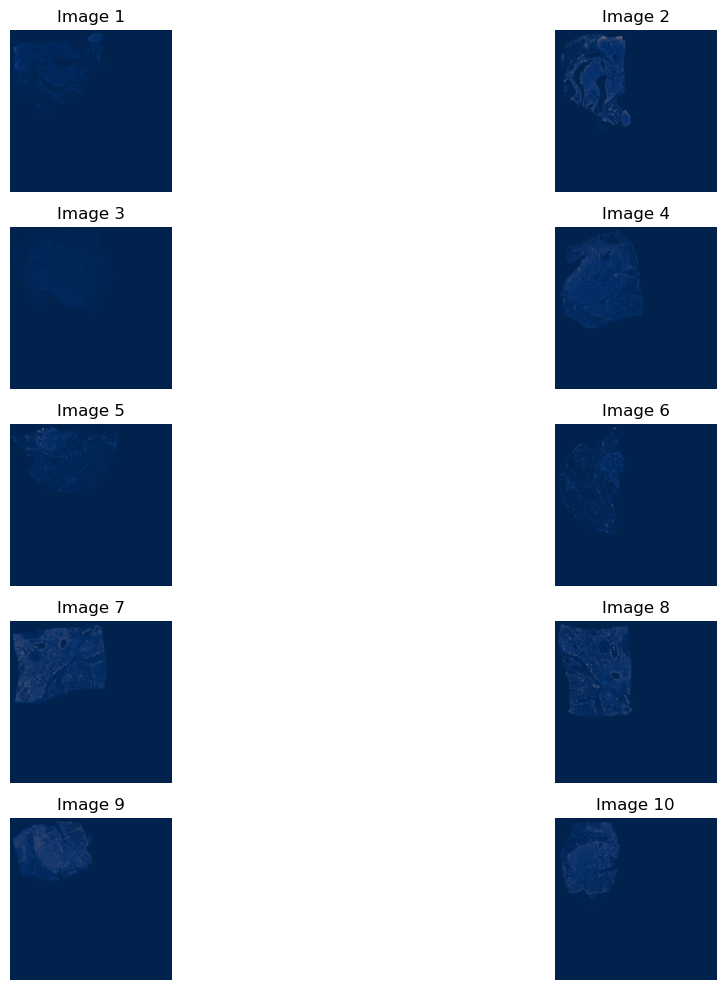

In [129]:
#Plot the first 10 images of padded images using plt with 5 rows and 2 columns
fig, axes = plt.subplots(5, 2, figsize=(15, 10))
axes = axes.flatten()
for i, (sampleid, padded_image) in enumerate(padded_images_ants_3.items()):
    if i < 10:
        axes[i].imshow(padded_image.numpy(), cmap='cividis')
        axes[i].set_title(f'Image {i+1}')
        axes[i].axis('off')
plt.tight_layout()
plt.show()

In [130]:
#Store odd and even images in separate lists: regression and tbet while keeping the key
# Create lists to store regression and tbet image
# images
regression_images_3 = []
tbet_images_3 = []
for i, (sampleid, padded_image) in enumerate(padded_images_ants_3.items()):
    if i % 2 == 0:  # Even index
        regression_images_3.append((sampleid, padded_image))
    else:  # Odd index
        tbet_images_3.append((sampleid, padded_image))
        

In [133]:
#Compute the scaling factor between an image from scale 7 and scale 5
scaling_factor_2 = compute_scaling_factor(sp.images[f'{list(sp.images)[0]}']['scale5'].image.transform['scale0'].scale[0], sp.images[f'{list(sp.images)[0]}']['scale7'].image.transform['scale0'].scale[0])
#Convert the scaling factors to be floats
scaling_factor_2 = float(scaling_factor_2)


In [134]:
#For each image in the registered images, scale the transformation matrix

transformation_matrices_scaled_2 = {}

for i, (reg_sampleid, reg_image) in enumerate(registered_images_scaled.items()):

    # Get the corresponding tbet image
    tbet_sampleid, tbet_image = tbet_images_3[i]

    # Get the transformation matrix
    transform_path = f'C:/Users/molanre1/Desktop/WSIFIR/scale_7_transform/reg_tbet/{reg_sampleid}_to_{tbet_sampleid}_0GenericAffine.mat'

    # Scale the transformation matrix
    scaled_transform_path_2 = scale_transform(transform_path, scaling_factor_2)

    #Store the scaled transformation matrix
    transformation_matrices_scaled_2[reg_sampleid] = scaled_transform_path_2


### ANTS Affine transform

In [135]:
#Perform the registration using the scaled transformation matrix
registered_images_scaled_2 = {}
for i, (reg_sampleid, reg_image) in enumerate(regression_images_3):
    # Get the corresponding tbet image
    tbet_sampleid, tbet_image = tbet_images_3[i]

    # Perform registration using the scaled transformation matrix
    registered_image_scaled_2 = ants.registration(fixed=reg_image, moving=tbet_image, initial_transform=transformation_matrices_scaled_2[reg_sampleid], type_of_transform='Affine', outprefix=f'C:/Users/molanre1/Desktop/WSIFIR/scale_5_transform/reg_tbet/{reg_sampleid}_to_{tbet_sampleid}_', verbose=True)

    # Store the registered image
    registered_images_scaled_2[reg_sampleid] = registered_image_scaled_2['warpedmovout']



antsRegistration -d 2 -r C:/Users/molanre1/Desktop/WSIFIR/scale_7_transform/reg_tbet/sampleid_709_image_to_sampleid_834_image_0GenericAffine_scaled.mat -m mattes[000001B3BE861A68,000001B3BE8620E8,1,32,regular,0.2] -t Affine[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:/Users/molanre1/Desktop/WSIFIR/scale_5_transform/reg_tbet/sampleid_709_image_to_sampleid_834_image_,000001B3BE861468,000001B3BE861F68] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r C:/Users/molanre1/Desktop/WSIFIR/scale_7_transform/reg_tbet/sampleid_710_image_to_sampleid_835_image_0GenericAffine_scaled.mat -m mattes[000001B3BE861A68,000001B3BE861468,1,32,regular,0.2] -t Affine[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:/Users/molanre1/Desktop/WSIFIR/scale_5_transform/reg_tbet/sampleid_710_image_to_sampleid_835_image_,000001B3BE8619C8,000001B3BA1B10E8] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r C:/Users/molanr

In [136]:
#Read the transformation matrices using ants.read_transform
transformation_matrices_scaled_2 = {}

for i, (reg_sampleid, reg_image) in enumerate(regression_images_3):
    # Get the corresponding tbet image
    tbet_sampleid, tbet_image = tbet_images_3[i]

    # Read the transformation matrix
    transformation_matrix = ants.read_transform(f'C:/Users/molanre1/Desktop/WSIFIR/scale_5_transform/reg_tbet/{reg_sampleid}_to_{tbet_sampleid}_0GenericAffine.mat')

    transformation_matrices_scaled_2[reg_sampleid] = transformation_matrix
# Get the parameters and fixed parameters of the transformation matrices
transformation_parameters_scaled_2 = {}
for sampleid, matrix in transformation_matrices_scaled_2.items():
    transformation_parameters_scaled_2[sampleid] = {
        'parameters': matrix.parameters,
        'fixed_parameters': matrix.fixed_parameters
    }
    

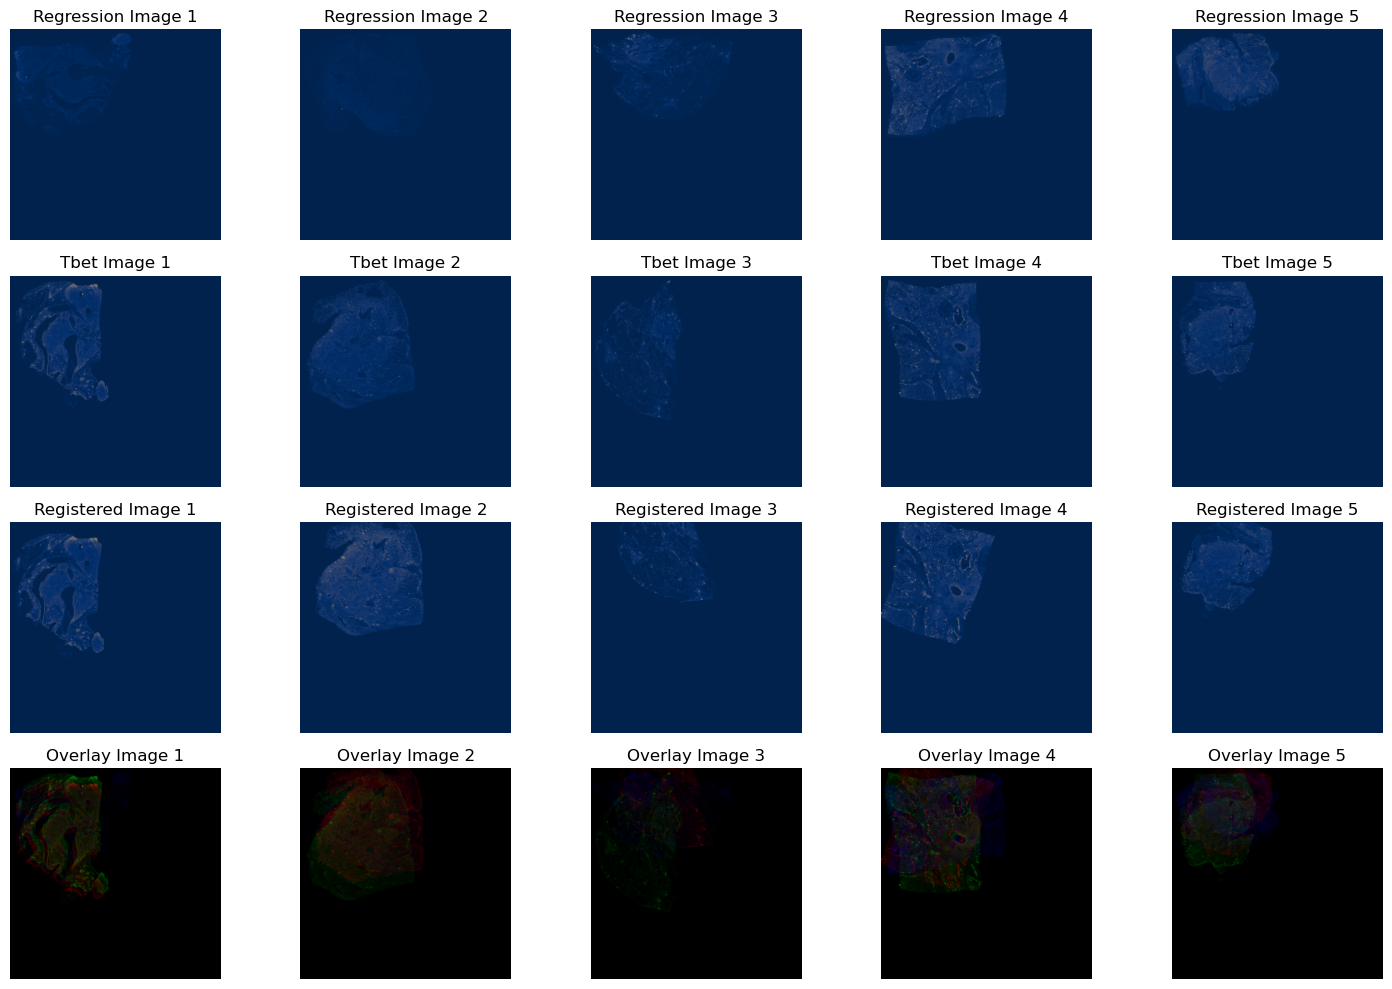

In [137]:
# Plot the first 5 regression images in one row, the corresponding tbet images in the second row,
# the registered images in the third row, and the overlay images in the last row.
fig, axes = plt.subplots(4, 5, figsize=(15, 10))
axes = axes.flatten()
# Plot regression images

for i, (sampleid, padded_image) in enumerate(regression_images_3):
    if i < 5:
        axes[i].imshow(padded_image.numpy(), cmap='cividis')
        axes[i].set_title(f'Regression Image {i+1}')
        axes[i].axis('off')
# Plot tbet images
for i, (sampleid, padded_image) in enumerate(tbet_images_3):
    if i < 5:
        axes[i + 5].imshow(padded_image.numpy(), cmap='cividis')
        axes[i + 5].set_title(f'Tbet Image {i+1}')
        axes[i + 5].axis('off')
# Plot registered images

for i, (sampleid, padded_image) in enumerate(registered_images_scaled_2.items()):
    if i < 5:
        axes[i + 10].imshow(padded_image.numpy(), cmap='cividis')
        axes[i + 10].set_title(f'Registered Image {i+1}')
        axes[i + 10].axis('off')
# Plot overlay images
for i, (reg_sampleid, reg_image) in enumerate(regression_images_3):
    if i < 5:
        # Get the corresponding tbet image
        tbet_sampleid, tbet_image = tbet_images_3[i]

        # Get the registered image
        registered_image = registered_images_scaled_2[reg_sampleid]

        # Normalize the images to 0-1 range
        registered_image = (registered_image - registered_image.min()) / (registered_image.max() - registered_image.min())
        tbet_image = (tbet_image - tbet_image.min()) / (tbet_image.max() - tbet_image.min())
        reg_image = (reg_image - reg_image.min()) / (reg_image.max() - reg_image.min())
        # Create a color image by stacking the images along the third dimension
        color_image = np.zeros((registered_image.shape[0], registered_image.shape[1], 3), dtype=np.float32)
        color_image[..., 0] = registered_image.numpy()
        color_image[..., 1] = tbet_image.numpy()
        color_image[..., 2] = reg_image.numpy()
        axes[i + 15].imshow(color_image)
        axes[i + 15].set_title(f'Overlay Image {i+1}')
        axes[i + 15].axis('off')

plt.tight_layout()
plt.show()

### Metrics

In [ ]:
#Create a DataFrame to store the metrics

metrics_df_3 = pd.DataFrame(columns=['reg_sampleid', 'tbet_sampleid', 'mutual_info', 'cross_corr', 'mse', 'jaccard_index', 'f1_score', 'hausdorff_distance'])
# Loop through each image and compute the metrics

for i, (reg_sampleid, reg_image) in enumerate(regression_images_3):

    # Get the corresponding tbet image
    tbet_sampleid, tbet_image = tbet_images_3[i]

    # Compute the metrics
    mutual_info, cross_corr, mse, jaccard_index, f1, hausdorff_distance = compute_metrics(reg_image, tbet_image)

    # Append the metrics to the DataFrame
    metrics_df_3 = pd.concat([metrics_df_3, pd.DataFrame({
        'reg_sampleid': [reg_sampleid],
        'tbet_sampleid': [tbet_sampleid],
        'mutual_info': [mutual_info],
        'cross_corr': [cross_corr],
        'mse': [mse],
        'jaccard_index': [jaccard_index],
        'f1_score': [f1],
        'hausdorff_distance': [hausdorff_distance]
    })], ignore_index=True)

metrics_df_3.head(10)

C:\Users\molanre1\AppData\Local\Temp\2\ipykernel_43772\1923429654.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df_3 = pd.concat([metrics_df_3, pd.DataFrame({


In [409]:
metrics_df_3.drop(columns=['reg_sampleid', 'tbet_sampleid'], inplace=True)

C:\Users\molanre1\AppData\Local\Temp\2\ipykernel_48412\3057915049.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df_registered_scaled_2 = pd.concat([metrics_df_registered_scaled_2, pd.DataFrame({


,reg_sampleid,tbet_sampleid,mutual_info,cross_corr,mse,jaccard_index,f1_score,hausdorff_distance
0,sampleid_709_image,sampleid_834_image,-0.168667,-0.334350,3.183779,0.686794,0.752246,29.546573
1,sampleid_710_image,sampleid_835_image,-0.278515,-0.552279,2.988925,0.593445,0.671602,18.027756
2,sampleid_712_image,sampleid_837_image,-0.190907,-0.306141,1.243031,0.719965,0.779955,17.691806
3,sampleid_713_image,sampleid_838_image,-0.177195,-0.324505,2.277347,0.610470,0.686591,26.419690
4,sampleid_714_image,sampleid_839_image,-0.124280,-0.273272,1.925208,0.773378,0.823899,27.513633
5,sampleid_715_image,sampleid_840_image,-0.224455,-0.387570,2.467588,0.655920,0.725975,21.400935
6,sampleid_678_image,sampleid_841_image,-0.071654,-0.136346,0.696385,0.892835,0.918719,41.773197
7,sampleid_679_image,sampleid_842_image,-0.001994,-0.001563,0.195008,0.975426,0.981811,78.262379
8,sampleid_716_image,sampleid_843_image,-0.129094,-0.216184,2.636147,0.747229,0.802642,25.961510
9,sampleid_717_image,sampleid_844_image,-0.221599,-0.405389,1.153580,0.743555,0.799641,23.600847


In [410]:
# Create a dataframe to store the metrics between the registered images and the regression images
metrics_df_registered_3 = pd.DataFrame(columns=['reg_sampleid', 'tbet_sampleid', 'mutual_info', 'cross_corr', 'mse', 'jaccard_index', 'f1_score', 'hausdorff_distance'])
# Loop through each image and compute the metrics

for i, (reg_sampleid, reg_image) in enumerate(registered_images_scaled_2.items()):
    # Get the corresponding tbet image
    tbet_sampleid, tbet_image = tbet_images_3[i]

    # Compute the metrics
    mutual_info, cross_corr, mse, jaccard_index, f1, hausdorff_distance = compute_metrics(reg_image, registered_image)

    # Append the metrics to the DataFrame
    metrics_df_registered_3 = pd.concat([metrics_df_registered_3, pd.DataFrame({
        'reg_sampleid': [reg_sampleid],
        'tbet_sampleid': [tbet_sampleid],
        'mutual_info': [mutual_info],
        'cross_corr': [cross_corr],
        'mse': [mse],
        'jaccard_index': [jaccard_index],   
        'f1_score': [f1],
        'hausdorff_distance': [hausdorff_distance]
    })], ignore_index=True)
metrics_df_registered_3.head(10)


,reg_sampleid,tbet_sampleid,mutual_info,cross_corr,mse,jaccard_index,f1_score,hausdorff_distance
0,sampleid_709_image,sampleid_834_image,0.022328,-0.000033,0.640950,-0.173868,-0.168817,19.546573
1,sampleid_710_image,sampleid_835_image,-0.035495,-0.050846,1.460647,-0.215349,-0.218671,2.216368
2,sampleid_712_image,sampleid_837_image,-0.122678,-0.216692,-0.731462,-0.034197,-0.065567,-15.414085
3,sampleid_713_image,sampleid_838_image,0.138387,0.176196,1.069704,-0.288057,-0.258730,19.139580
4,sampleid_714_image,sampleid_839_image,0.072626,0.220499,0.713410,-0.122701,-0.117873,11.021210
5,sampleid_715_image,sampleid_840_image,-0.021596,-0.037469,0.534661,-0.173599,-0.176320,6.978729
6,sampleid_678_image,sampleid_841_image,-0.051698,-0.104889,-0.531471,0.013340,-0.002879,7.291318
7,sampleid_679_image,sampleid_842_image,-0.001866,-0.001473,-0.190423,0.009613,0.004893,8.048420
8,sampleid_716_image,sampleid_843_image,0.065491,0.213421,0.907960,-0.128693,-0.126741,11.961510
9,sampleid_717_image,sampleid_844_image,-0.156616,-0.323945,-0.676934,-0.019982,-0.053212,-8.021929


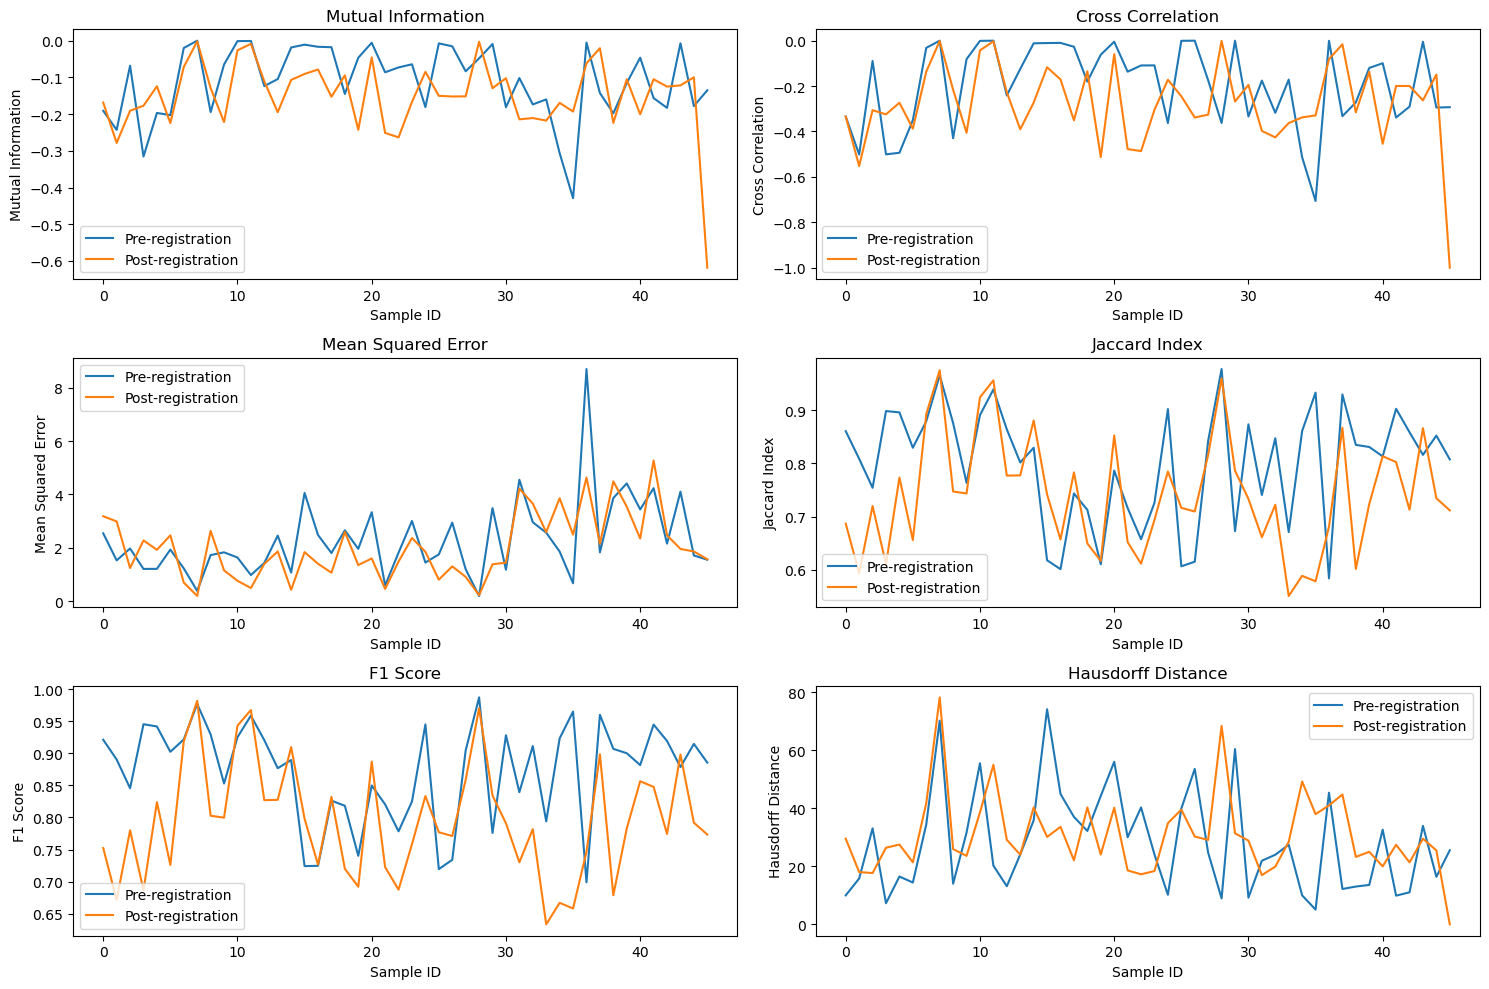

In [411]:
metrics_df_registered_3.drop(columns=['reg_sampleid', 'tbet_sampleid'], inplace=True)   

In [414]:
# Compute the mean and standard deviation of the metrics
mean_metrics_3 = metrics_df_3.mean()
std_metrics_3 = metrics_df_3.std()
mean_metrics_registered_3 = metrics_df_registered_3.mean()
std_metrics_registered_3 = metrics_df_registered_3.std()
# Create a DataFrame to store the mean and standard deviation of the metrics
mean_std_df_3 = pd.DataFrame({
    'mean': mean_metrics_3,
    'std': std_metrics_3
}).reset_index()
mean_std_df_3.columns = ['metric', 'mean', 'std']
mean_std_df_registered_3 = pd.DataFrame({
    'mean': mean_metrics_registered_3,
    'std': std_metrics_registered_3
}).reset_index()

mean_std_df_registered_3.columns = ['metric', 'mean', 'std']

,reg_sampleid,tbet_sampleid,final_image_parameters,final_image_fixed_parameters
0,sampleid_709_image,sampleid_834_image,"[0.9980692267417908, 0.0015516475541517138, -0...","[37.25094223022461, 53.06191635131836]"
1,sampleid_710_image,sampleid_835_image,"[0.9980692267417908, 0.0015516475541517138, -0...","[37.25094223022461, 53.06191635131836]"
2,sampleid_712_image,sampleid_837_image,"[0.9980692267417908, 0.0015516475541517138, -0...","[37.25094223022461, 53.06191635131836]"
3,sampleid_713_image,sampleid_838_image,"[0.9980692267417908, 0.0015516475541517138, -0...","[37.25094223022461, 53.06191635131836]"
4,sampleid_714_image,sampleid_839_image,"[0.9980692267417908, 0.0015516475541517138, -0...","[37.25094223022461, 53.06191635131836]"
5,sampleid_715_image,sampleid_840_image,"[0.9980692267417908, 0.0015516475541517138, -0...","[37.25094223022461, 53.06191635131836]"
6,sampleid_678_image,sampleid_841_image,"[0.9980692267417908, 0.0015516475541517138, -0...","[37.25094223022461, 53.06191635131836]"
7,sampleid_679_image,sampleid_842_image,"[0.9980692267417908, 0.0015516475541517138, -0...","[37.25094223022461, 53.06191635131836]"
8,sampleid_716_image,sampleid_843_image,"[0.9980692267417908, 0.0015516475541517138, -0...","[37.25094223022461, 53.06191635131836]"
9,sampleid_717_image,sampleid_844_image,"[0.9980692267417908, 0.0015516475541517138, -0...","[37.25094223022461, 53.06191635131836]"


In [415]:
# Plot grouped bar plot with subplots for each metric
fig, axes = plt.subplots(3, 2, figsize=(20, 10))
# Flatten the axes array for easier indexing
axes = axes.flatten()
# Set the figure title
fig.suptitle('Metrics Comparison', fontsize=16)
# Set the bar width
bar_width = 0.35
# Set the bar positions
r1 = np.arange(len(mean_std_df_3))
r2 = [x + bar_width for x in r1]
# Set the colors for the bars
colors = ['#1f77b4', '#ff7f0e']
# Set the bar labels
bar_labels = ['Before Registration', 'After Registration']
# Set the metrics to plot
metrics_to_plot_3 = ['mutual_info', 'cross_corr', 'mse', 'jaccard_index', 'f1_score', 'hausdorff_distance']
# Loop through each metric and plot the bars with error bars

for i, metric in enumerate(metrics_to_plot_3):
    # Filter data for the current metric
    mean_before = mean_std_df_3[mean_std_df_3['metric'] == metric]['mean']
    std_before = mean_std_df_3[mean_std_df_3['metric'] == metric]['std']
    mean_after = mean_std_df_registered_3[mean_std_df_registered_3['metric'] == metric]['mean']
    std_after = mean_std_df_registered_3[mean_std_df_registered_3['metric'] == metric]['std']

    # Create the bar plot with error bars
    axes[i].bar(r1, mean_before, yerr=std_before, color=colors[0], width=bar_width, edgecolor='grey', label=bar_labels[0], capsize=5)
    axes[i].bar(r2, mean_after, yerr=std_after, color=colors[1], width=bar_width, edgecolor='grey', label=bar_labels[1], capsize=5)

    # Set the x-ticks and labels
    axes[i].set_xticks([r + bar_width / 2 for r in range(len(mean_std_df_3))])
    axes[i].set_xticklabels(mean_std_df_3['metric'])


    # Set the title and labels
    axes[i].set_title(metric)
    axes[i].set_xlabel('Metrics')
    axes[i].set_ylabel('Value')
    axes[i].legend()

    # Set grid lines
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)
# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

In [ ]:
#Compute the difference between the metrics of the mean and standard deviation OF the registered images and the regression images
diff_mean_metrics_3 = mean_std_df_registered_3['mean'] - mean_std_df_3['mean']
#Convert the cross correlation and mutual info to absolute values
diff_mean_metrics_3[0] = abs(diff_mean_metrics_3[0])
diff_mean_metrics_3[1] = abs(diff_mean_metrics_3[1])

# Create a DataFrame to store the difference between the metrics
diff_mean_df_3 = pd.DataFrame({
    'metric': mean_std_df_3['metric'],
    'diff_mean': diff_mean_metrics_3
}).reset_index(drop=True)

diff_mean_df_3

In [ ]:
#Save the merged DataFrame to a CSV file
diff_mean_df_3.to_csv('C:/Users/molanre1/Desktop/WSIFIR/scale_5_transform/reg_tbet_metrics_diff_mean_df.csv', index=False)

## Affine Registration (Scale 3)

### Load in spatial data

In [3]:
# Loop through each image in sp.images and crop it
cropped_images_4 = {}
for sampleid in sp.images:
    cropped_images_4[sampleid] = tl.crop_xarray_image(sp.images[sampleid], scale=3)[0]

NameError: name 'sp' is not defined

In [84]:
#Convert all images to numpy arrays
cropped_images_arrays_4 = {}
for sampleid, cropped_image in cropped_images_4.items():
    cropped_images_arrays_4[sampleid] = cropped_image.compute()
    

In [ ]:
#Convert all images to ants images
cropped_images_ants_4 = {}
for sampleid, cropped_image in cropped_images_arrays_4.items():
    cropped_images_ants_4[sampleid] = ants.from_numpy(cropped_image)
cropped_images_ants_4


### Pad Images

In [1]:
# Pad the images
padded_images_4 = pad_images_to_same_size(cropped_images_ants_4)
# Convert the padded images to ANTs images
padded_images_ants_4 = {}
for sampleid, padded_image in padded_images_4.items():
    padded_images_ants_4[sampleid] = ants.from_numpy(padded_image)
    

NameError: name 'cropped_images_arrays_4' is not defined

In [86]:
#Plot the first 10 images of padded images using plt with 5 rows and 2 columns
fig, axes = plt.subplots(5, 2, figsize=(15, 10))
axes = axes.flatten()
for i, (sampleid, padded_image) in enumerate(padded_images_ants_4.items()):
    if i < 10:
        axes[i].imshow(padded_image.numpy(), cmap='cividis')
        axes[i].set_title(f'Image {i+1}')
        axes[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
#Compute the scaling factor between an image from scale 5 and scale 3
scaling_factor_3 = compute_scaling_factor(sp.images[f'{list(sp.images)[0]}']['scale3'].image.transform['scale0'].scale[0], sp.images[f'{list(sp.images)[0]}']['scale5'].image.transform['scale0'].scale[0])
#Convert the scaling factors to be floats
scaling_factor_3 = float(scaling_factor_3)

In [ ]:
#For each image in the registered images, scale the transformation matrix
for i, (reg_sampleid, reg_image) in enumerate(registered_images_scaled_2.items()):
    # Get the corresponding tbet image
    tbet_sampleid, tbet_image = tbet_images[i]

    # Get the transformation matrix
    transform_path = f'C:/Users/molanre1/Desktop/WSIFIR/scale_5_transform/reg_tbet/{reg_sampleid}_to_{tbet_sampleid}_0GenericAffine.mat'

    # Scale the transformation matrix
    scaled_transform_path = scale_transform(transform_path, scaling_factor_3)

### ANTS Affine transform

In [ ]:
#Perform the registration using the scaled transformation matrix
# Create a dictionary to store the registered images

registered_images_scaled_3 = {}
# Loop through each image and perform the registration

for i, (reg_sampleid, reg_image) in enumerate(registered_images_scaled_2.items()):

    # Get the corresponding tbet image
    tbet_sampleid, tbet_image = tbet_images[i]
    # Perform registration using the scaled transformation matrix
    registered_image_scaled_3 = ants.registration(fixed=reg_image, moving=tbet_image, type_of_transform='Affine', aff_metric='MeanSquares', outprefix=f'C:/Users/molanre1/Desktop/WSIFIR/scale_3_transform/reg_tbet/{reg_sampleid}_to_{tbet_sampleid}_', verbose=True)
    # Store the registered image
    registered_images_scaled_3[reg_sampleid] = registered_image_scaled_3['warpedmovout']

    #Apply the transformation to the moving image

    transformed_image_scaled_3 = ants.apply_transforms(fixed=reg_image, moving=tbet_image, transformlist=registered_image_scaled_3['fwdtransforms'])


In [ ]:
#Read the transformation matrices using ants.read_transform
transformation_matrices_scaled_3 = {}

for i, (reg_sampleid, reg_image) in enumerate(registered_images_scaled_3.items()):
    # Get the corresponding tbet image
    tbet_sampleid, tbet_image = tbet_images[i]

    # Read the transformation matrix
    transformation_matrix_scaled_3 = ants.read_transform(f'C:/Users/molanre1/Desktop/WSIFIR/scale_3_transform/reg_tbet/{reg_sampleid}_to_{tbet_sampleid}_0GenericAffine.mat')
   
    # Store the transformation matrix
    transformation_matrices_scaled_3[reg_sampleid] = transformation_matrix_scaled_3


In [ ]:
# Overlay the first 10 registered images on the corresponding tbet images and regression images
# using red, green, and blue channels
fig, axes = plt.subplots(5, 2, figsize=(15, 10))
axes = axes.flatten()

for i, (reg_sampleid, reg_image) in enumerate(registered_images_scaled_3.items()):
    # Get the corresponding tbet image
    tbet_sampleid, tbet_image = tbet_images[i]

    # Get the registered image
    registered_image_scaled_3 = registered_images_scaled_3[reg_sampleid]

    # Normalize the images to 0-1 range
    registered_image_scaled_3 = (registered_image_scaled_3 - registered_image_scaled_3.min()) / (registered_image_scaled_3.max() - registered_image_scaled_3.min())
    tbet_image = (tbet_image - tbet_image.min()) / (tbet_image.max() - tbet_image.min())
    reg_image = (reg_image - reg_image.min()) / (reg_image.max() - reg_image.min())

    # Create a color image by stacking the images along the third dimension
    color_image = np.zeros((registered_image_scaled_3.shape[0], registered_image_scaled_3.shape[1], 3), dtype=np.float32)
    color_image[..., 0] = registered_image_scaled_3.numpy()  # Red channel (registered image)
    color_image[..., 1] = tbet_image.numpy()  # Green channel (tbet image)
    color_image[..., 2] = reg_image.numpy()  # Blue channel (regression image)

    if i < 10:
        axes[i].imshow(color_image)
        axes[i].set_title(f'Overlay Image {i+1}')
        axes[i].axis('off')

### Metrics

In [89]:
#Create a DataFrame to store the metrics
metrics_df_scaled_3 = pd.DataFrame(columns=['reg_sampleid', 'tbet_sampleid', 'mutual_info', 'cross_corr', 'mse', 'jaccard_index', 'f1_score', 'hausdorff_distance'])
# Loop through each image and compute the metrics

for i, (reg_sampleid, reg_image) in enumerate(registered_images_scaled_3.items()):
    # Get the corresponding tbet image
    tbet_sampleid, tbet_image = tbet_images[i]

    # Compute the metrics
    mutual_info, cross_corr, mse, jaccard_index, f1, hausdorff_distance = compute_metrics(reg_image, tbet_image)

    # Append the metrics to the DataFrame
    metrics_df_scaled_3 = pd.concat([metrics_df_scaled_3, pd.DataFrame({
        'reg_sampleid': [reg_sampleid],
        'tbet_sampleid': [tbet_sampleid],
        'mutual_info': [mutual_info],
        'cross_corr': [cross_corr],
        'mse': [mse],
        'jaccard_index': [jaccard_index],
        'f1_score': [f1],
        'hausdorff_distance': [hausdorff_distance]
    })], ignore_index=True) 

metrics_df_scaled_3.head(10)

antsRegistration -d 2 -r C:\Users\molanre1\Desktop\WSIFIR\reg_tbet_affine_registration_image7_0GenericAffine_scaled.mat -m Mattes[000001BF8670E7A8,000001BF9D06B208,1,32,regular,0.2] -t Affine[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:\Users\molanre1\Desktop\WSIFIR\reg_tbet_affine_registration_image10_,000001BFB86ECC28,000001BFB872D108] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r C:\Users\molanre1\Desktop\WSIFIR\reg_tbet_affine_registration_image8_0GenericAffine_scaled.mat -m Mattes[000001BFB872D108,000001BFB86C9CC8,1,32,regular,0.2] -t Affine[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:\Users\molanre1\Desktop\WSIFIR\reg_tbet_affine_registration_image11_,000001BF9D06B208,000001BFB872E6E8] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r C:\Users\molanre1\Desktop\WSIFIR\reg_tbet_affine_registration_image9_0GenericAffine_scaled.mat -m Mattes[000001BF9D06B088,000001BF9D06B1C8,1,

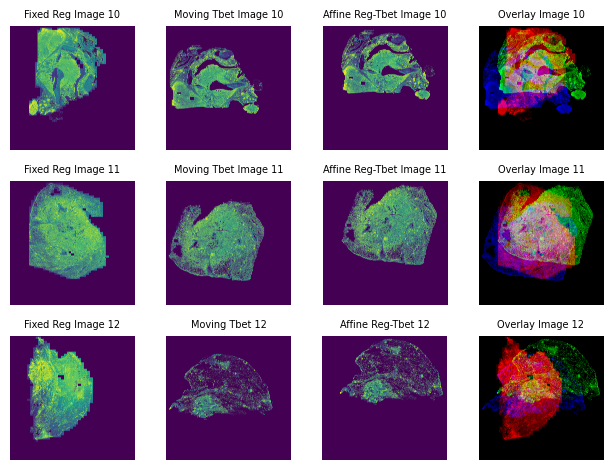

In [253]:
#Create a dataframe to store the metrics between the registered images and the regression images
metrics_df_registered_scaled_3 = pd.DataFrame(columns=['reg_sampleid', 'tbet_sampleid', 'mutual_info', 'cross_corr', 'mse', 'jaccard_index', 'f1_score', 'hausdorff_distance'])
# Loop through each image and compute the metrics
for i, (reg_sampleid, reg_image) in enumerate(registered_images_scaled_3.items()):
    # Get the corresponding tbet image
    tbet_sampleid, tbet_image = tbet_images[i]

    # Compute the metrics
    mutual_info, cross_corr, mse, jaccard_index, f1, hausdorff_distance = compute_metrics(reg_image, registered_image_scaled_3)

    # Append the metrics to the DataFrame
    metrics_df_registered_scaled_3 = pd.concat([metrics_df_registered_scaled_3, pd.DataFrame({
        'reg_sampleid': [reg_sampleid],
        'tbet_sampleid': [tbet_sampleid],
        'mutual_info': [mutual_info],
        'cross_corr': [cross_corr],
        'mse': [mse],
        'jaccard_index': [jaccard_index],
        'f1_score': [f1],
        'hausdorff_distance': [hausdorff_distance]
    })], ignore_index=True)

metrics_df_registered_scaled_3.head(10)

In [ ]:
# Compute the difference between the metrics of the registered images and the regression images
metrics_diff_scaled_3 = metrics_df_registered_scaled_3.copy()
metrics_diff_scaled_3['mutual_info'] = metrics_df_registered_scaled_3['mutual_info'] - metrics_df_scaled_3['mutual_info']
metrics_diff_scaled_3['cross_corr'] = metrics_df_registered_scaled_3['cross_corr'] - metrics_df_scaled_3['cross_corr']
metrics_diff_scaled_3['mse'] = metrics_df_registered_scaled_3['mse'] - metrics_df_scaled_3['mse']
metrics_diff_scaled_3['jaccard_index'] = metrics_df_registered_scaled_3['jaccard_index'] - metrics_df_scaled_3['jaccard_index']
metrics_diff_scaled_3['f1_score'] = metrics_df_registered_scaled_3['f1_score'] - metrics_df_scaled_3['f1_score']
metrics_diff_scaled_3['hausdorff_distance'] = metrics_df_registered_scaled_3['hausdorff_distance'] - metrics_df_scaled_3['hausdorff_distance']
metrics_diff_scaled_3.head(10)


In [90]:
#create a figure with subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
axs = axs.flatten()
# Plot each metric
axs[0].plot(metrics_df_scaled_3['mutual_info'], label='Pre-registration')
axs[0].plot(metrics_df_registered_scaled_3['mutual_info'], label='Post-registration')
axs[0].set_title('Mutual Information')
axs[0].set_xlabel('Sample ID')
axs[0].set_ylabel('Mutual Information')
axs[0].legend()
axs[1].plot(metrics_df_scaled_3['cross_corr'], label='Pre-registration')
axs[1].plot(metrics_df_registered_scaled_3['cross_corr'], label='Post-registration')
axs[1].set_title('Cross Correlation')
axs[1].set_xlabel('Sample ID')
axs[1].set_ylabel('Cross Correlation')
axs[1].legend()
axs[2].plot(metrics_df_scaled_3['mse'], label='Pre-registration')
axs[2].plot(metrics_df_registered_scaled_3['mse'], label='Post-registration')
axs[2].set_title('Mean Squared Error')
axs[2].set_xlabel('Sample ID')
axs[2].set_ylabel('Mean Squared Error')
axs[2].legend()
axs[3].plot(metrics_df_scaled_3['jaccard_index'], label='Pre-registration')
axs[3].plot(metrics_df_registered_scaled_3['jaccard_index'], label='Post-registration')
axs[3].set_title('Jaccard Index')
axs[3].set_xlabel('Sample ID')
axs[3].set_ylabel('Jaccard Index')
axs[3].legend()
axs[4].plot(metrics_df_scaled_3['f1_score'], label='Pre-registration')
axs[4].plot(metrics_df_registered_scaled_3['f1_score'], label='Post-registration')
axs[4].set_title('F1 Score')
axs[4].set_xlabel('Sample ID')
axs[4].set_ylabel('F1 Score')
axs[4].legend()
axs[5].plot(metrics_df_scaled_3['hausdorff_distance'], label='Pre-registration')
axs[5].plot(metrics_df_registered_scaled_3['hausdorff_distance'], label='Post-registration')
axs[5].set_title('Hausdorff Distance')
axs[5].set_xlabel('Sample ID')
axs[5].set_ylabel('Hausdorff Distance')
axs[5].legend()
plt.tight_layout()
plt.show()







{'warpedmovout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (8192, 8192)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, -1024.0)
 	 Direction  : [1. 0. 0. 1.],
 'warpedfixout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (8192, 8192)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (-1024.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'fwdtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image10_0GenericAffine.mat'],
 'invtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image10_0GenericAffine.mat']}

In [ ]:
#Convert each set of corresponding tissue slices into a DataFrame
#Each row has the same tissue, but 2 different slices representing the same tissue stained with regression and tbet panels
# Create a DataFrame to store the merged images
merged_df_scaled_3 = pd.DataFrame(columns=['reg_sampleid', 'tbet_sampleid','final_image_parameters', 'final_image_fixed_parameters'])
# Loop through each image and concate to the DataFrame

for i, (reg_sampleid, reg_image) in enumerate(registered_images_scaled_3.items()):
    # Get the corresponding tbet image
    tbet_sampleid, tbet_image = tbet_images[i]

    # Append the metrics to the DataFrame

    merged_df_scaled_3 = pd.concat([merged_df_scaled_3, pd.DataFrame({
        'reg_sampleid': [reg_sampleid],
        'tbet_sampleid': [tbet_sampleid],
        'final_image_parameters': [transformation_matrix_scaled_3.parameters],
        'final_image_fixed_parameters': [transformation_matrix_scaled_3.fixed_parameters]
    })], ignore_index=True)
merged_df_scaled_3.head(10)


In [ ]:
merged_df_scaled_3.to_csv('C:/Users/molanre1/Desktop/WSIFIR/xform_reg_to_tbet_scale_3.csv', index=False)

## Symmetric Deformable Registration (Scale 2)

### Load in spatial data

In [111]:
#Loop through each image in sp.images and crop it
cropped_images_5 = {}
for sampleid in sp.images:
    cropped_images_5[sampleid] = tl.crop_xarray_image(sp.images[sampleid], scale=2)[0]


#Create a dataframe with a columnn named panel that loops either axis, regression and tbet 3 time
panel_5 = ['regression','tbet']*3
panel_df_5 = pd.DataFrame(panel, columns=['panel'])

#Save dimensions of the cropped images to a dataframe
cropped_images_dimensions_5 = {}
for sampleid, cropped_image in cropped_images_5.items():
    cropped_images_dimensions_5[sampleid] = {
        'dimensions': cropped_image.shape,
        'data_type': cropped_image.dtype,
        'coordinates': cropped_image.coords,
    }

cropped_images_dimensions_df_5 = pd.DataFrame.from_dict(cropped_images_dimensions_5, orient='index')
#Add the panel column to the cropped images dimensions dataframe
cropped_images_dimensions_df_5['panel'] = panel_df_5['panel'].values
cropped_images_dimensions_df_5

,dimensions,data_type,coordinates,panel
sampleid_709_image,"(16384, 12288)",float32,"[c, y, x]",regression
sampleid_834_image,"(12288, 16384)",float32,"[c, y, x]",tbet
sampleid_710_image,"(16384, 12288)",float32,"[c, y, x]",regression
sampleid_835_image,"(12288, 16384)",float32,"[c, y, x]",tbet
sampleid_712_image,"(16384, 12288)",float32,"[c, y, x]",regression
sampleid_837_image,"(12288, 16384)",float32,"[c, y, x]",tbet


In [112]:
#Convret the cropped images to ants
reg_image_cropped_ants_13 = ants.from_numpy(cropped_images_5[f'sampleid_{results[0]["reg_sampleid"]}_image'].compute().data)
tbet_image_cropped_ants_13 = ants.from_numpy(cropped_images_5[f'sampleid_{results[0]["tbet_sampleid"]}_image'].compute().data)

reg_image_cropped_ants_14 = ants.from_numpy(cropped_images_5[f'sampleid_{results[1]["reg_sampleid"]}_image'].compute().data)
tbet_image_cropped_ants_14 = ants.from_numpy(cropped_images_5[f'sampleid_{results[1]["tbet_sampleid"]}_image'].compute().data)

reg_image_cropped_ants_15 = ants.from_numpy(cropped_images_5[f'sampleid_{results[2]["reg_sampleid"]}_image'].compute().data)
tbet_image_cropped_ants_15 = ants.from_numpy(cropped_images_5[f'sampleid_{results[2]["tbet_sampleid"]}_image'].compute().data)

In [114]:
#Pad the images so they are the same size

reg_image_cropped_shape_13 = reg_image_cropped_ants_13.shape
tbet_image_cropped_shape_13= tbet_image_cropped_ants_13.shape

reg_image_cropped_shape_14 = reg_image_cropped_ants_14.shape
tbet_image_cropped_shape_14= tbet_image_cropped_ants_14.shape

reg_image_cropped_shape_15 = reg_image_cropped_ants_15.shape
tbet_image_cropped_shape_15= tbet_image_cropped_ants_15.shape


#Get the target shapes for padding
target_shape_13_x = max(reg_image_cropped_shape_13[0],tbet_image_cropped_shape_13[0])
target_shape_13_y = max(reg_image_cropped_shape_13[1],tbet_image_cropped_shape_13[1])

target_shape_14_x = max(reg_image_cropped_shape_14[0],tbet_image_cropped_shape_14[0])
target_shape_14_y = max(reg_image_cropped_shape_14[1],tbet_image_cropped_shape_14[1])

target_shape_15_x = max(reg_image_cropped_shape_15[0],tbet_image_cropped_shape_15[0])
target_shape_15_y = max(reg_image_cropped_shape_15[1],tbet_image_cropped_shape_15[1])

#Calculate the padding
pad_reg_X_13 = (0,target_shape_13_x-reg_image_cropped_shape_13[0])
pad_reg_Y_13 = (0,target_shape_13_y-reg_image_cropped_shape_13[1])

pad_reg_X_14 = (0,target_shape_14_x-reg_image_cropped_shape_14[0])
pad_reg_Y_14 = (0,target_shape_14_y-reg_image_cropped_shape_14[1])

pad_reg_X_15 = (0,target_shape_15_x-reg_image_cropped_shape_15[0])
pad_reg_Y_15 = (0,target_shape_15_y-reg_image_cropped_shape_15[1])

# Pad the cropped images to match the size of the rigid transformed images
reg_image_cropped_ants_13_padded = ants.pad_image(reg_image_cropped_ants_13, (target_shape_13_x,target_shape_13_y))
reg_image_cropped_ants_14_padded = ants.pad_image(reg_image_cropped_ants_14, (target_shape_14_x,target_shape_14_y))
reg_image_cropped_ants_15_padded = ants.pad_image(reg_image_cropped_ants_15, (target_shape_15_x,target_shape_15_y))

# Pad the tbet images to match the size of the rigid transformed images
tbet_image_cropped_ants_13_padded = ants.pad_image(tbet_image_cropped_ants_13, (target_shape_13_x,target_shape_13_y))
tbet_image_cropped_ants_14_padded = ants.pad_image(tbet_image_cropped_ants_14, (target_shape_14_x,target_shape_14_y))
tbet_image_cropped_ants_15_padded = ants.pad_image(tbet_image_cropped_ants_15, (target_shape_15_x,target_shape_15_y))

# Print the shapes of the padded images
print("Padded regression image shape 13: ", reg_image_cropped_ants_13_padded.shape)
print("Padded regression image shape 14: ", reg_image_cropped_ants_14_padded.shape)
print("Padded regression image shape 15: ", reg_image_cropped_ants_15_padded.shape,"\n")

print("Padded tbet image shape 13: ", tbet_image_cropped_ants_13_padded.shape)
print("Padded tbet image shape 14: ", tbet_image_cropped_ants_14_padded.shape)
print("Padded tbet image shape 15: ", tbet_image_cropped_ants_15_padded.shape,"\n")


Padded regression image shape 13:  (16384, 16384)
Padded regression image shape 14:  (16384, 16384)
Padded regression image shape 15:  (16384, 16384) 

Padded tbet image shape 13:  (16384, 16384)
Padded tbet image shape 14:  (16384, 16384)
Padded tbet image shape 15:  (16384, 16384) 



### Scale and apply registration parameters at lower resolution to higher resolution image

In [115]:
# Compute scaling factors
scaling_factor_10 = compute_scaling_factor(sp.images[f'{reg_name_1}']['scale2'].image.transform['scale0'].scale[0], sp.images[f'{reg_name_1}']['scale3'].image.transform['scale0'].scale[0])
scaling_factor_11 = compute_scaling_factor(sp.images[f'{reg_name_2}']['scale2'].image.transform['scale0'].scale[0], sp.images[f'{reg_name_2}']['scale3'].image.transform['scale0'].scale[0])
scaling_factor_12 = compute_scaling_factor(sp.images[f'{reg_name_3}']['scale2'].image.transform['scale0'].scale[0], sp.images[f'{reg_name_3}']['scale3'].image.transform['scale0'].scale[0])

### ANTS Symmetric Deformable transform

In [ ]:
#Divide image into sections


In [329]:

#Apply the scaling factors to the transformations
scaled_transform_13 = scale_transform(
    'C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image7_0GenericAffine.mat',
    scaling_factor_10
)

# Apply the scaled transformation to the image
affine_transformed_image_13 = ants.apply_transforms(
    fixed=reg_image_cropped_ants_13_padded,
    moving=tbet_image_cropped_ants_13_padded,
    transformlist=scaled_transform_13
)

# Perform SyN registration first on the image
syn_result_13 = ants.registration(  
    fixed=affine_transformed_image_13,
    moving=tbet_image_cropped_ants_13_padded,
    type_of_transform='SyN',
    verbose=True,
    outprefix='C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_syn_registration_image13_'
)

# Apply the scaling factors to the transformations
scaled_transform_14 = scale_transform(
    'C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image8_0GenericAffine.mat',
    scaling_factor_11
)

# Apply the scaled transformation to the image
affine_transformed_image_14 = ants.apply_transforms(
    fixed=reg_image_cropped_ants_14_padded,
    moving=tbet_image_cropped_ants_14_padded,
    transformlist=scaled_transform_14
)

# Perform SyN registration first on the image
syn_result_14 = ants.registration( 
    fixed=affine_transformed_image_14,
    moving=tbet_image_cropped_ants_14_padded,
    type_of_transform='SyN',
    verbose=True,
    outprefix='C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_syn_registration_image14_'
)

# Apply the scaling factors to the transformations
scaled_transform_15 = scale_transform(
    'C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image9_0GenericAffine.mat',
    scaling_factor_12
)

# Apply the scaled transformation to the image
affine_transformed_image_15 = ants.apply_transforms(
    fixed=reg_image_cropped_ants_15_padded,
    moving=tbet_image_cropped_ants_15_padded,
    transformlist=scaled_transform_15
)

# Perform SyN registration first on the image
syn_result_15 = ants.registration(
    fixed=affine_transformed_image_15,
    moving=tbet_image_cropped_ants_15_padded,
    type_of_transform='SyN',
    verbose=True,
    outprefix='C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_syn_registration_image15_'
)

RuntimeError: D:\a\ANTsPy\ANTsPy\itksource\Modules\Core\Common\include\itkImportImageContainer.hxx:179:
Failed to allocate memory for image.

In [ ]:
#Visualize the results
plt.subplot(3,4,1)
fixed_10 = exposure.equalize_hist(reg_image_cropped_ants_10_padded.numpy())
plt.imshow(fixed_10)
plt.title('Fixed Reg Image 10',fontsize=7)
plt.axis('off')

plt.subplot(3,4,2)
moving_10 = exposure.equalize_hist(tbet_image_cropped_ants_10_padded.numpy())
plt.imshow(moving_10)
plt.title('Moving Tbet Image 10',fontsize=7)
plt.axis('off')

plt.subplot(3,4,3)
registered_10 = exposure.equalize_hist(affine_result_10['warpedmovout'].numpy())
plt.imshow(registered_10)
plt.title('Affine Reg-Tbet Image 10',fontsize=7)
plt.axis('off')

# Normalize the images to [0, 1] for proper overlay visualization
fixed_10_normalized = (fixed_10 - fixed_10.min()) / (fixed_10.max() - fixed_10.min())
registered_10_normalized = (registered_10 - registered_10.min()) / (registered_10.max() - registered_10.min())
moving_10_normalized = (moving_10 - moving_10.min()) / (moving_10.max() - moving_10.min())

#Overlay for the first image
plt.subplot(3, 4, 4)
overlay_10 = np.stack([fixed_10_normalized, registered_10_normalized, moving_10_normalized], axis=-1)  # Red for fixed, Blue for moving. Green for registered
plt.imshow(overlay_10)
plt.title('Overlay Image 10', fontsize=7)
plt.axis('off')

plt.subplot(3,4,5)
fixed_11 = exposure.equalize_hist(reg_image_cropped_ants_11_padded.numpy())
plt.imshow(fixed_11)
plt.title('Fixed Reg Image 11',fontsize=7)
plt.axis('off')

plt.subplot(3,4,6)
moving_11 = exposure.equalize_hist(tbet_image_cropped_ants_11_padded.numpy())
plt.imshow(moving_11)
plt.title('Moving Tbet Image 11', fontsize=7)
plt.axis('off')

plt.subplot(3,4,7)
registered_11 = exposure.equalize_hist(affine_result_11['warpedmovout'].numpy())
plt.imshow(registered_11)
plt.title('Affine Reg-Tbet Image 11',fontsize=7)

plt.axis('off')
# Normalize the images to [0, 1] for proper overlay visualization
fixed_11_normalized = (fixed_11 - fixed_11.min()) / (fixed_11.max() - fixed_11.min())
registered_11_normalized = (registered_11 - registered_11.min()) / (registered_11.max() - registered_11.min())
moving_11_normalized = (moving_11 - moving_11.min()) / (moving_11.max() - moving_11.min())

#Overlay for the second image
plt.subplot(3, 4, 8)
overlay_11 = np.stack([fixed_11_normalized, registered_11_normalized, moving_11_normalized], axis=-1)  # Red for fixed, Blue for moving. Green for registered
plt.imshow(overlay_11)
plt.title('Overlay Image 11', fontsize=7)
plt.axis('off')

plt.subplot(3,4,9)
fixed_12 = exposure.equalize_hist(reg_image_cropped_ants_12_padded.numpy())
plt.imshow(fixed_12)
plt.title('Fixed Reg Image 12',fontsize=7)
plt.axis('off')

plt.subplot(3,4,10)
moving_12 = exposure.equalize_hist(tbet_image_cropped_ants_12_padded.numpy())
plt.imshow(moving_12)
plt.title('Moving Tbet 12',fontsize=7)
plt.axis('off')

plt.subplot(3,4,11)
registered_12 = exposure.equalize_hist(affine_result_12['warpedmovout'].numpy())
plt.imshow(registered_12)
plt.title('Affine Reg-Tbet 12',fontsize=7)
plt.axis('off')

# Normalize the images to [0, 1] for proper overlay visualization
fixed_12_normalized = (fixed_12 - fixed_12.min()) / (fixed_12.max() - fixed_12.min())
registered_12_normalized = (registered_12 - registered_12.min()) / (registered_12.max() - registered_12.min())
moving_12_normalized = (moving_12 - moving_12.min()) / (moving_12.max() - moving_12.min())

#Overlay for the third image
plt.subplot(3,4,12)
overlay_12 = np.stack([fixed_12_normalized, registered_12_normalized, moving_12_normalized], axis=-1)  # Red for fixed, Blue for moving. Green for registered
plt.imshow(overlay_12)
plt.title('Overlay Image 12', fontsize=7)
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#One matrix should be zeros as it the one being registered to the other. 
#Two tables one for axis and one for tbet. Tbet to regression and axis to regression
#Similarity metrics from transformed axis to regression. Transformed tbet to regression. Transformed axis to tbet (could be to validate registration)


In [ ]:

#Sources:

# https://pmc.ncbi.nlm.nih.gov/articles/PMC7584382/

#https://pubmed.ncbi.nlm.nih.gov/38632390/ 

#https://www.nature.com/articles/s41598-021-87564-6 

#Multi-resolution registration:
#https://discourse.itk.org/t/multiresolution-registration-with-2d-affine-transformation-on-pairs-of-2d-images/3096/10